In [1]:
import time

import numpy as np
import pandas as pd
from finrl.apps import config
from finrl.finrl_meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.finrl_meta.preprocessor.preprocessors import data_split
from stable_baselines3 import A2C, DDPG, PPO, SAC, TD3
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.noise import (
    NormalActionNoise,
    OrnsteinUhlenbeckActionNoise,
)
from stable_baselines3.common.vec_env import DummyVecEnv
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg')
%matplotlib inline
import datetime
import statistics
import seaborn as sns
from finrl.apps import config
from finrl.finrl_meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.finrl_meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.finrl_meta.env_portfolio_allocation.env_portfolio import StockPortfolioEnv
from finrl.drl_agents.stablebaselines3.models import DRLAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline,convert_daily_return_to_pyfolio_ts
from finrl.finrl_meta.data_processor import DataProcessor
from finrl.finrl_meta.data_processors.processor_yahoofinance import YahooFinanceProcessor
import sys
sys.path.append("../FinRL-Library")

/home/alia880801/anaconda3/envs/aa/lib/python3.7/site-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; multipliers will not be applied'


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import random
import torch
def set_seed(seed_value):
    random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

set_seed(100)

In [4]:

MODELS = {"a2c": A2C, "ddpg": DDPG, "td3": TD3, "sac": SAC, "ppo": PPO}

MODEL_KWARGS = {x: config.__dict__[f"{x.upper()}_PARAMS"] for x in MODELS.keys()}

NOISE = {
    "normal": NormalActionNoise,
    "ornstein_uhlenbeck": OrnsteinUhlenbeckActionNoise,
}

In [15]:
import numpy as np
import pandas as pd
from gym.utils import seeding
import gym
from gym import spaces
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from stable_baselines3.common.vec_env import DummyVecEnv


class StockPortfolioEnv(gym.Env):
    """A single stock trading environment for OpenAI gym

    Attributes
    ----------
        df: DataFrame
            input data
        stock_dim : int
            number of unique stocks
        hmax : int
            maximum number of shares to trade
        initial_amount : int
            start money
        transaction_cost_pct: float
            transaction cost percentage per trade
        reward_scaling: float
            scaling factor for reward, good for training
        state_space: int
            the dimension of input features
        action_space: int
            equals stock dimension
        tech_indicator_list: list
            a list of technical indicator names
        turbulence_threshold: int
            a threshold to control risk aversion
        day: int
            an increment number to control date

    Methods
    -------
    _sell_stock()
        perform sell action based on the sign of the action
    _buy_stock()
        perform buy action based on the sign of the action
    step()
        at each step the agent will return actions, then 
        we will calculate the reward, and return the next observation.
    reset()
        reset the environment
    render()
        use render to return other functions
    save_asset_memory()
        return account value at each time step
    save_action_memory()
        return actions/positions at each time step
        

    """
    metadata = {'render.modes': ['human']}

    def __init__(self, 
                df,
                stock_dim,
                hmax,
                initial_amount,
                transaction_cost_pct,
                reward_scaling,
                state_space,
                action_space,
                tech_indicator_list,
                reward_by = 'reward',
                turbulence_threshold=None,
                lookback=252,
                day = 0):
        #super(StockEnv, self).__init__()
        #money = 10 , scope = 1
        self.day = day
        self.lookback=lookback
        self.df = df
        self.stock_dim = stock_dim
        self.hmax = hmax
        self.initial_amount = initial_amount
        self.transaction_cost_pct =transaction_cost_pct
        self.reward_scaling = reward_scaling
        self.state_space = state_space
        self.action_space = action_space
        self.tech_indicator_list = tech_indicator_list
        self.max_portfolio_value = 0        
        self.mdd = 0.0001
        self.reward_by = reward_by
        self.return_list = []
        self.pre_value = initial_amount


        # action_space normalization and shape is self.stock_dim
        self.action_space = spaces.Box(low = 0, high = 1,shape = (self.action_space,)) 
        # Shape = (34, 30)
        # covariance matrix + technical indicators
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape = (self.state_space+len(self.tech_indicator_list),self.state_space))

        # load data from a pandas dataframe
        self.data = self.df.loc[self.day,:]
        self.covs = self.data['cov_list'].values[0]
        self.state =  np.append(np.array(self.covs), [self.data[tech].values.tolist() for tech in self.tech_indicator_list ], axis=0)
        self.terminal = False     
        self.turbulence_threshold = turbulence_threshold        
        # initalize state: inital portfolio return + individual stock return + individual weights
        self.portfolio_value = self.initial_amount

        # memorize portfolio value each step
        self.asset_memory = [self.initial_amount]
        # memorize portfolio return each step
        self.portfolio_return_memory = [0]
        self.actions_memory=[[1/self.stock_dim]*self.stock_dim]
        self.date_memory=[self.data.date.unique()[0]]

        
    def step(self, actions):
        # print(self.day)
        self.terminal = self.day >= len(self.df.index.unique())-1
#         print(actions)

        if self.terminal:
            df = pd.DataFrame(self.portfolio_return_memory)
            df.columns = ['daily_return']
            plt.plot(df.daily_return.cumsum(),'r')
            plt.savefig('results/cumulative_reward.png')
            plt.close()
            
            plt.plot(self.portfolio_return_memory,'r')
            plt.savefig('results/rewards.png')
            plt.close()

            print("=================================")
            print("begin_total_asset:{}".format(self.asset_memory[0]))           
            print("end_total_asset:{}".format(self.portfolio_value))

            df_daily_return = pd.DataFrame(self.portfolio_return_memory)
            df_daily_return.columns = ['daily_return']
            if df_daily_return['daily_return'].std() !=0:
              sharpe = (252**0.5)*df_daily_return['daily_return'].mean()/ \
                       df_daily_return['daily_return'].std()
              print("Sharpe: ",sharpe)
            print("=================================")
            
            return self.state, self.reward, self.terminal,{}

        else:
            #print("Model actions: ",actions)
            # actions are the portfolio weight
            # normalize to sum of 1
            #if (np.array(actions) - np.array(actions).min()).sum() != 0:
            #  norm_actions = (np.array(actions) - np.array(actions).min()) / (np.array(actions) - np.array(actions).min()).sum()
            #else:
            #  norm_actions = actions
            weights = self.softmax_normalization(actions) 
            #print("Normalized actions: ", weights)
            self.actions_memory.append(weights)
            last_day_memory = self.data

            #load next state
            self.day += 1
            self.data = self.df.loc[self.day,:]
            self.covs = self.data['cov_list'].values[0]
            self.state =  np.append(np.array(self.covs), [self.data[tech].values.tolist() for tech in self.tech_indicator_list ], axis=0)
            #print(self.state)
            # calcualte portfolio return
            # individual stocks' return * weight
            portfolio_return = sum(((self.data.close.values / last_day_memory.close.values)-1)*weights)
            # update portfolio value
            new_portfolio_value = self.portfolio_value*(1+portfolio_return)
            self.portfolio_value = new_portfolio_value

            # save into memory
            self.portfolio_return_memory.append(portfolio_return)
            self.date_memory.append(self.data.date.unique()[0])            
            self.asset_memory.append(new_portfolio_value)

            # the reward is the new portfolio value or end portfolo value
            if self.reward_by=='reward':
                self.reward = new_portfolio_value 
            # self.reward = (new_portfolio_value-self.initial_amount)/self.initial_amount
            elif self.reward_by=='mdd':
                now_return = (new_portfolio_value-self.initial_amount)/self.initial_amount
                ann_return = (1+now_return) ** (252/self.day) -1
                if self.max_portfolio_value <  new_portfolio_value :
                    self.max_portfolio_value = new_portfolio_value
                now_dd = 1-(new_portfolio_value/self.max_portfolio_value)
                if self.mdd < now_dd:
                    self.mdd = now_dd   
                self.reward = 1/(self.mdd+0.0001)
            elif self.reward_by=='1mstdev':
                rrr = (new_portfolio_value-self.pre_value)/self.pre_value
                self.return_list.append(rrr)
#                 print(self.return_list)
                if len(self.return_list)<21:
                    self.reward = 0
                else:
                    self.return_list.pop(0)
                    stdev = statistics.stdev(self.return_list)
                    if stdev==0:
                        self.reward = 1/(stdev+0.0001)
                    else:
                        self.reward = 1/stdev
#             self.reward = ann_return+(1/self.mdd)
#             print(ann_return)
#             print("Step reward: ", self.reward)
#             self.reward = self.reward*self.reward_scaling

        return self.state, self.reward, self.terminal, {}

    def reset(self):
        self.asset_memory = [self.initial_amount]
        self.day = 0
        self.data = self.df.loc[self.day,:]
        # load states
        self.covs = self.data['cov_list'].values[0]
        self.state =  np.append(np.array(self.covs), [self.data[tech].values.tolist() for tech in self.tech_indicator_list ], axis=0)
        self.portfolio_value = self.initial_amount
        #self.cost = 0
        #self.trades = 0
        self.terminal = False 
        self.portfolio_return_memory = [0]
        self.actions_memory=[[1/self.stock_dim]*self.stock_dim]
        self.date_memory=[self.data.date.unique()[0]] 
        return self.state
    
    def render(self, mode='human'):
        return self.state
        
    def softmax_normalization(self, actions):
        numerator = np.exp(actions)
        denominator = np.sum(np.exp(actions))
        softmax_output = numerator/denominator
        return softmax_output

    
    def save_asset_memory(self):
        date_list = self.date_memory
        portfolio_return = self.portfolio_return_memory
        #print(len(date_list))
        #print(len(asset_list))
        df_account_value = pd.DataFrame({'date':date_list,'daily_return':portfolio_return})
        return df_account_value

    def save_action_memory(self):
        # date and close price length must match actions length
        date_list = self.date_memory
        df_date = pd.DataFrame(date_list)
        df_date.columns = ['date']
        
        action_list = self.actions_memory
        df_actions = pd.DataFrame(action_list)
        df_actions.columns = self.data.tic.values
        df_actions.index = df_date.date
        #df_actions = pd.DataFrame({'date':date_list,'actions':action_list})
        return df_actions

    def _seed(self, seed=None):
        seed = 100
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def get_sb_env(self):
        e = DummyVecEnv([lambda: self])
        obs = e.reset()
        return e, obs

In [6]:
def get_data(etfs):
    dp = YahooFinanceProcessor()
    df = dp.download_data(start_date = '2008-01-01',
                     end_date = '2021-12-31',
                     ticker_list = etfs, time_interval='1D')
    fe = FeatureEngineer(
                    use_technical_indicator=True,
                    use_vix=True,
                    use_turbulence=True,
                    user_defined_feature = False)

    df = fe.preprocess_data(df)
    # add covariance matrix as states
    df=df.sort_values(['date','tic'],ignore_index=True)
    df.index = df.date.factorize()[0]

    cov_list = []
    return_list = []

    # look back is one year
    lookback=252
    for i in range(lookback,len(df.index.unique())):
        data_lookback = df.loc[i-lookback:i,:]
        price_lookback=data_lookback.pivot_table(index = 'date',columns = 'tic', values = 'close')
        return_lookback = price_lookback.pct_change().dropna()
        return_list.append(return_lookback)

        covs = return_lookback.cov().values 
        cov_list.append(covs)

    df_cov = pd.DataFrame({'date':df.date.unique()[lookback:],'cov_list':cov_list,'return_list':return_list})
    df = df.merge(df_cov, on='date')
    df = df.sort_values(['date','tic']).reset_index(drop=True)
    return df

In [7]:
org_etfs = ['ITOT', 'VEU', 'VNQ', 'AGG']
org_df = get_data(org_etfs)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (14104, 9)
Successfully added technical indicators
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (3525, 8)
Successfully added vix
Successfully added turbulence index


In [8]:
def train_rl(df,start_date,end_date,initial_amount=1000000,reward_by='reward'): #reward_by='reward','mdd','1mstdev'

    
    train = data_split(df, start_date,end_date)
    stock_dimension = len(train.tic.unique())
    state_space = stock_dimension
    print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")
    
    env_kwargs = {
        "hmax": 100, 
        "initial_amount": initial_amount, 
        "transaction_cost_pct": 0.001, 
        "state_space": state_space, 
        "stock_dim": stock_dimension, 
        "tech_indicator_list": config.TECHNICAL_INDICATORS_LIST, 
        "action_space": stock_dimension, 
        "reward_scaling": 1e-4,
        "reward_by":reward_by
    }
    
    e_train_gym = StockPortfolioEnv(df = train, **env_kwargs)
    env_train, _ = e_train_gym.get_sb_env()
    
    agent = DRLAgent(env = env_train)
    PPO_PARAMS = {
        "n_steps": 2048,
        "ent_coef": 0.005,
        "learning_rate": 0.0001,
        "batch_size": 128,
    }
    model_ppo = agent.get_model("ppo",seed=100,model_kwargs = PPO_PARAMS)
#     enable_dropout(model_ppo)
    trained_ppo = agent.train_model(model=model_ppo, 
                             tb_log_name='ppo',
                             total_timesteps=100000)
#     trained_ppo.save('trained_models/trained_ppo.zip')
    return trained_ppo

In [9]:
def trade_rl(df,start_date,end_date,trained_model,initial_amount=1000000,reward_by='reward'):
    trade = data_split(df,start_date,end_date)
    stock_dimension = len(trade.tic.unique())
    state_space = stock_dimension
    env_kwargs = {
        "hmax": 100, 
        "initial_amount": initial_amount, 
        "transaction_cost_pct": 0.001, 
        "state_space": state_space, 
        "stock_dim": stock_dimension, 
        "tech_indicator_list": config.TECHNICAL_INDICATORS_LIST, 
        "action_space": stock_dimension, 
        "reward_scaling": 1e-4,
        "reward_by":reward_by
    }
    e_trade_gym = StockPortfolioEnv(df = trade, **env_kwargs)
    df_daily_return, df_actions = DRLAgent.DRL_prediction(model=trained_model, environment = e_trade_gym)
    return df_daily_return, df_actions

In [17]:
reward_by_list=['reward','mdd','1mstdev']

org_train_start = '2009-01-01'
org_train_end = '2016-01-01'
org_initial_amount = 1000000
models = []
for i in range(len(reward_by_list)):
# for i in range(2,3):

    print(i)
    trained_model = train_rl(org_df,org_train_start,org_train_end,org_initial_amount,reward_by_list[i])
    models.append(trained_model)


0
Stock Dimension: 4, State Space: 4
{'n_steps': 2048, 'ent_coef': 0.005, 'learning_rate': 0.0001, 'batch_size': 128}
Using cuda device
gaussian dist net
begin_total_asset:1000000
end_total_asset:1674387.747599486
Sharpe:  0.5190736429611892
----------------------------------
| time/              |           |
|    fps             | 720       |
|    iterations      | 1         |
|    time_elapsed    | 2         |
|    total_timesteps | 2048      |
| train/             |           |
|    reward          | 1205589.1 |
----------------------------------
begin_total_asset:1000000
end_total_asset:1751150.4631331584
Sharpe:  0.5620778322843231
-------------------------------------------
| time/                   |               |
|    fps                  | 657           |
|    iterations           | 2             |
|    time_elapsed         | 6             |
|    total_timesteps      | 4096          |
| train/                  |               |
|    approx_kl            | 4.6102854e-05 |
| 

begin_total_asset:1000000
end_total_asset:1835901.2182496565
Sharpe:  0.6145064204931665
-------------------------------------------
| time/                   |               |
|    fps                  | 629           |
|    iterations           | 10            |
|    time_elapsed         | 32            |
|    total_timesteps      | 20480         |
| train/                  |               |
|    approx_kl            | 5.0060917e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -5.68         |
|    explained_variance   | 1.19e-07      |
|    learning_rate        | 0.0001        |
|    loss                 | 2.67e+14      |
|    n_updates            | 90            |
|    policy_gradient_loss | 4.5e-05       |
|    reward               | 1667871.4     |
|    std                  | 1             |
|    value_loss           | 5.42e+14      |
-------------------------------------------
begin_total_asset:1000000
end_t

begin_total_asset:1000000
end_total_asset:1731742.9478045362
Sharpe:  0.5554272992195641
------------------------------------------
| time/                   |              |
|    fps                  | 622          |
|    iterations           | 18           |
|    time_elapsed         | 59           |
|    total_timesteps      | 36864        |
| train/                  |              |
|    approx_kl            | 4.271287e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -5.68        |
|    explained_variance   | 5.96e-08     |
|    learning_rate        | 0.0001       |
|    loss                 | 3.09e+14     |
|    n_updates            | 170          |
|    policy_gradient_loss | -0.00012     |
|    reward               | 1810356.5    |
|    std                  | 1            |
|    value_loss           | 6.03e+14     |
------------------------------------------
begin_total_asset:1000000
end_total_asset:1799365.5

begin_total_asset:1000000
end_total_asset:1749565.7585382941
Sharpe:  0.5588176267179259
------------------------------------------
| time/                   |              |
|    fps                  | 619          |
|    iterations           | 26           |
|    time_elapsed         | 85           |
|    total_timesteps      | 53248        |
| train/                  |              |
|    approx_kl            | 4.530573e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -5.68        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0001       |
|    loss                 | 3.01e+14     |
|    n_updates            | 250          |
|    policy_gradient_loss | 2.71e-05     |
|    reward               | 1261309.0    |
|    std                  | 1            |
|    value_loss           | 6.02e+14     |
------------------------------------------
begin_total_asset:1000000
end_total_asset:1718707.3

begin_total_asset:1000000
end_total_asset:1800046.1141521586
Sharpe:  0.5914030358531984
-------------------------------------------
| time/                   |               |
|    fps                  | 615           |
|    iterations           | 34            |
|    time_elapsed         | 113           |
|    total_timesteps      | 69632         |
| train/                  |               |
|    approx_kl            | 4.6774076e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -5.68         |
|    explained_variance   | 0             |
|    learning_rate        | 0.0001        |
|    loss                 | 2.64e+14      |
|    n_updates            | 330           |
|    policy_gradient_loss | 2.4e-05       |
|    reward               | 1502541.9     |
|    std                  | 1             |
|    value_loss           | 5.3e+14       |
-------------------------------------------
begin_total_asset:1000000
end_t

begin_total_asset:1000000
end_total_asset:1959300.794994131
Sharpe:  0.6637370215597607
-------------------------------------------
| time/                   |               |
|    fps                  | 614           |
|    iterations           | 42            |
|    time_elapsed         | 139           |
|    total_timesteps      | 86016         |
| train/                  |               |
|    approx_kl            | 4.8336224e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -5.68         |
|    explained_variance   | 0             |
|    learning_rate        | 0.0001        |
|    loss                 | 3.32e+14      |
|    n_updates            | 410           |
|    policy_gradient_loss | 0.000148      |
|    reward               | 1612776.0     |
|    std                  | 1             |
|    value_loss           | 6.76e+14      |
-------------------------------------------
begin_total_asset:1000000
end_to

1
Stock Dimension: 4, State Space: 4
{'n_steps': 2048, 'ent_coef': 0.005, 'learning_rate': 0.0001, 'batch_size': 128}
Using cuda device
gaussian dist net
begin_total_asset:1000000
end_total_asset:1674387.747599486
Sharpe:  0.5190736429611892
----------------------------------
| time/              |           |
|    fps             | 738       |
|    iterations      | 1         |
|    time_elapsed    | 2         |
|    total_timesteps | 2048      |
| train/             |           |
|    reward          | 1.6497284 |
----------------------------------
begin_total_asset:1000000
end_total_asset:1752556.1337516888
Sharpe:  0.5622902139029589
------------------------------------------
| time/                   |              |
|    fps                  | 676          |
|    iterations           | 2            |
|    time_elapsed         | 6            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0037776832 |
|    clip_

begin_total_asset:1000000
end_total_asset:1844969.6514093073
Sharpe:  0.621118970127155
------------------------------------------
| time/                   |              |
|    fps                  | 629          |
|    iterations           | 10           |
|    time_elapsed         | 32           |
|    total_timesteps      | 20480        |
| train/                  |              |
|    approx_kl            | 0.0069850865 |
|    clip_fraction        | 0.0651       |
|    clip_range           | 0.2          |
|    entropy_loss         | -5.71        |
|    explained_variance   | -0.00434     |
|    learning_rate        | 0.0001       |
|    loss                 | 245          |
|    n_updates            | 90           |
|    policy_gradient_loss | -0.00471     |
|    reward               | 1.5679494    |
|    std                  | 1.01         |
|    value_loss           | 527          |
------------------------------------------
begin_total_asset:1000000
end_total_asset:1704652.46

begin_total_asset:1000000
end_total_asset:1740679.1976550885
Sharpe:  0.560463035630584
-----------------------------------------
| time/                   |             |
|    fps                  | 617         |
|    iterations           | 18          |
|    time_elapsed         | 59          |
|    total_timesteps      | 36864       |
| train/                  |             |
|    approx_kl            | 0.008634403 |
|    clip_fraction        | 0.0891      |
|    clip_range           | 0.2         |
|    entropy_loss         | -5.74       |
|    explained_variance   | -0.000561   |
|    learning_rate        | 0.0001      |
|    loss                 | 207         |
|    n_updates            | 170         |
|    policy_gradient_loss | -0.0026     |
|    reward               | 1.5243189   |
|    std                  | 1.02        |
|    value_loss           | 434         |
-----------------------------------------
begin_total_asset:1000000
end_total_asset:1815766.6799762102
Sharpe:  0.

begin_total_asset:1000000
end_total_asset:1742933.9740424682
Sharpe:  0.5568170783010158
-----------------------------------------
| time/                   |             |
|    fps                  | 614         |
|    iterations           | 26          |
|    time_elapsed         | 86          |
|    total_timesteps      | 53248       |
| train/                  |             |
|    approx_kl            | 0.008159779 |
|    clip_fraction        | 0.0725      |
|    clip_range           | 0.2         |
|    entropy_loss         | -5.81       |
|    explained_variance   | -0.000314   |
|    learning_rate        | 0.0001      |
|    loss                 | 175         |
|    n_updates            | 250         |
|    policy_gradient_loss | -0.00479    |
|    reward               | 1.4775316   |
|    std                  | 1.04        |
|    value_loss           | 370         |
-----------------------------------------
begin_total_asset:1000000
end_total_asset:1729504.012771968
Sharpe:  0.

-----------------------------------------
| time/                   |             |
|    fps                  | 615         |
|    iterations           | 34          |
|    time_elapsed         | 113         |
|    total_timesteps      | 69632       |
| train/                  |             |
|    approx_kl            | 0.006503798 |
|    clip_fraction        | 0.0704      |
|    clip_range           | 0.2         |
|    entropy_loss         | -5.82       |
|    explained_variance   | -6.79e-05   |
|    learning_rate        | 0.0001      |
|    loss                 | 143         |
|    n_updates            | 330         |
|    policy_gradient_loss | -0.00265    |
|    reward               | 1.4775316   |
|    std                  | 1.04        |
|    value_loss           | 301         |
-----------------------------------------
begin_total_asset:1000000
end_total_asset:1690340.1533736975
Sharpe:  0.5284086289786749
------------------------------------------
| time/                   | 

------------------------------------------
| time/                   |              |
|    fps                  | 614          |
|    iterations           | 42           |
|    time_elapsed         | 139          |
|    total_timesteps      | 86016        |
| train/                  |              |
|    approx_kl            | 0.0073013618 |
|    clip_fraction        | 0.0616       |
|    clip_range           | 0.2          |
|    entropy_loss         | -5.81        |
|    explained_variance   | -2.77e-05    |
|    learning_rate        | 0.0001       |
|    loss                 | 119          |
|    n_updates            | 410          |
|    policy_gradient_loss | -0.00527     |
|    reward               | 1.4775316    |
|    std                  | 1.04         |
|    value_loss           | 258          |
------------------------------------------
begin_total_asset:1000000
end_total_asset:1633770.6995924448
Sharpe:  0.5043241303337449
-----------------------------------------
| time/  

----------------------------------
| time/              |           |
|    fps             | 651       |
|    iterations      | 1         |
|    time_elapsed    | 3         |
|    total_timesteps | 2048      |
| train/             |           |
|    reward          | 58.673454 |
----------------------------------
begin_total_asset:1000000
end_total_asset:1745403.231743299
Sharpe:  0.55989438429703
------------------------------------------
| time/                   |              |
|    fps                  | 601          |
|    iterations           | 2            |
|    time_elapsed         | 6            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0013425694 |
|    clip_fraction        | 0.000146     |
|    clip_range           | 0.2          |
|    entropy_loss         | -5.68        |
|    explained_variance   | -6.76e-05    |
|    learning_rate        | 0.0001       |
|    loss                 | 5.78e+05    

begin_total_asset:1000000
end_total_asset:1829987.7138577856
Sharpe:  0.6162384916921495
------------------------------------------
| time/                   |              |
|    fps                  | 563          |
|    iterations           | 10           |
|    time_elapsed         | 36           |
|    total_timesteps      | 20480        |
| train/                  |              |
|    approx_kl            | 0.0021806397 |
|    clip_fraction        | 0.00859      |
|    clip_range           | 0.2          |
|    entropy_loss         | -5.69        |
|    explained_variance   | 0.000186     |
|    learning_rate        | 0.0001       |
|    loss                 | 7.45e+05     |
|    n_updates            | 90           |
|    policy_gradient_loss | -0.00202     |
|    reward               | 45.22796     |
|    std                  | 1            |
|    value_loss           | 1.52e+06     |
------------------------------------------
begin_total_asset:1000000
end_total_asset:1693250.2

begin_total_asset:1000000
end_total_asset:1728704.0149877428
Sharpe:  0.5588601942023878
------------------------------------------
| time/                   |              |
|    fps                  | 559          |
|    iterations           | 18           |
|    time_elapsed         | 65           |
|    total_timesteps      | 36864        |
| train/                  |              |
|    approx_kl            | 0.0040906044 |
|    clip_fraction        | 0.0273       |
|    clip_range           | 0.2          |
|    entropy_loss         | -5.69        |
|    explained_variance   | 4.87e-05     |
|    learning_rate        | 0.0001       |
|    loss                 | 7.35e+05     |
|    n_updates            | 170          |
|    policy_gradient_loss | -0.00125     |
|    reward               | 52.074043    |
|    std                  | 1            |
|    value_loss           | 1.49e+06     |
------------------------------------------
begin_total_asset:1000000
end_total_asset:1808165.7

begin_total_asset:1000000
end_total_asset:1719922.3117959292
Sharpe:  0.5498553277761118
-----------------------------------------
| time/                   |             |
|    fps                  | 554         |
|    iterations           | 26          |
|    time_elapsed         | 95          |
|    total_timesteps      | 53248       |
| train/                  |             |
|    approx_kl            | 0.004076944 |
|    clip_fraction        | 0.0369      |
|    clip_range           | 0.2         |
|    entropy_loss         | -5.71       |
|    explained_variance   | 2.07e-05    |
|    learning_rate        | 0.0001      |
|    loss                 | 6.55e+05    |
|    n_updates            | 250         |
|    policy_gradient_loss | -0.000774   |
|    reward               | 45.719677   |
|    std                  | 1.01        |
|    value_loss           | 1.36e+06    |
-----------------------------------------
begin_total_asset:1000000
end_total_asset:1704503.0162003443
Sharpe:  0

begin_total_asset:1000000
end_total_asset:1772321.3901197757
Sharpe:  0.5832209351969017
------------------------------------------
| time/                   |              |
|    fps                  | 554          |
|    iterations           | 34           |
|    time_elapsed         | 125          |
|    total_timesteps      | 69632        |
| train/                  |              |
|    approx_kl            | 0.0038965596 |
|    clip_fraction        | 0.0298       |
|    clip_range           | 0.2          |
|    entropy_loss         | -5.71        |
|    explained_variance   | 6.62e-06     |
|    learning_rate        | 0.0001       |
|    loss                 | 8.29e+05     |
|    n_updates            | 330          |
|    policy_gradient_loss | -0.000743    |
|    reward               | 76.69644     |
|    std                  | 1.01         |
|    value_loss           | 1.61e+06     |
------------------------------------------
begin_total_asset:1000000
end_total_asset:1697376.0

begin_total_asset:1000000
end_total_asset:1944029.9118436386
Sharpe:  0.6602616683295635
-----------------------------------------
| time/                   |             |
|    fps                  | 552         |
|    iterations           | 42          |
|    time_elapsed         | 155         |
|    total_timesteps      | 86016       |
| train/                  |             |
|    approx_kl            | 0.003893322 |
|    clip_fraction        | 0.0348      |
|    clip_range           | 0.2         |
|    entropy_loss         | -5.7        |
|    explained_variance   | 3.46e-06    |
|    learning_rate        | 0.0001      |
|    loss                 | 5.71e+05    |
|    n_updates            | 410         |
|    policy_gradient_loss | 0.000604    |
|    reward               | 64.168816   |
|    std                  | 1.01        |
|    value_loss           | 1.34e+06    |
-----------------------------------------
begin_total_asset:1000000
end_total_asset:1603762.7251751658
Sharpe:  0

In [18]:
org_trade_start = '2016-01-01' 
org_trade_end = '2021-01-01'
trade_action_list = []
trade_return_list = []
for i in range(len(reward_by_list)):
    trained_model = models[i]
#     train_df_daily_return, train_df_actions = trade_rl(org_df,org_train_start,org_train_end,trained_model,org_initial_amount)
    trade_df_daily_return, trade_df_actions = trade_rl(org_df,org_trade_start,org_trade_end,trained_model,org_initial_amount,reward_by_list[i])
    trade_action_list.append(trade_df_actions)
    trade_return_list.append(trade_df_daily_return)

begin_total_asset:1000000
end_total_asset:1408882.6195910473
Sharpe:  0.5628527695358273
hit end!
begin_total_asset:1000000
end_total_asset:1342536.8178686772
Sharpe:  0.48162783835333467
hit end!
begin_total_asset:1000000
end_total_asset:1315310.714368522
Sharpe:  0.45589498698840636
hit end!


In [19]:
org_trade_start = '2016-01-01' 
org_trade_end = '2021-01-01'
trade_action_list = []
trade_return_list = []
trained_model = models[0]
for j in range(250):
    print((j))
    action_tmp = []
    reward_tmp = []
    for i in range(len(reward_by_list)):
        trained_model = models[i]
        trade_df_daily_return, trade_df_actions = trade_rl(org_df,org_trade_start,org_trade_end,trained_model,org_initial_amount)
        action_tmp.append(trade_df_actions)
        trade_df_daily_return['daily_return']+=1
        reward_tmp.append(trade_df_daily_return)

    df_concat = pd.concat(action_tmp)
    by_row_index = df_concat.groupby(df_concat.index)
    final_action = by_row_index.mean()
    trade_action_list.append(final_action)
    
    df_concat = pd.concat(reward_tmp)
    by_row_index = df_concat.groupby(df_concat.index)
    final_reward = by_row_index.mean()-1
    trade_return_list.append(final_reward)

0
begin_total_asset:1000000
end_total_asset:1436795.140759272
Sharpe:  0.5805406817769333
hit end!
begin_total_asset:1000000
end_total_asset:1405953.052506073
Sharpe:  0.5551882310829022
hit end!
begin_total_asset:1000000
end_total_asset:1310966.959157615
Sharpe:  0.4524121354206931
hit end!
1
begin_total_asset:1000000
end_total_asset:1408982.132986932
Sharpe:  0.5448944377325576
hit end!
begin_total_asset:1000000
end_total_asset:1382838.3155219003
Sharpe:  0.5262581871734983
hit end!
begin_total_asset:1000000
end_total_asset:1402695.0257461593
Sharpe:  0.5572798709096254
hit end!
2
begin_total_asset:1000000
end_total_asset:1404959.642059211
Sharpe:  0.543337271182493
hit end!
begin_total_asset:1000000
end_total_asset:1391806.2057049929
Sharpe:  0.5311068914840805
hit end!
begin_total_asset:1000000
end_total_asset:1388434.3437696963
Sharpe:  0.5468907379207976
hit end!
3
begin_total_asset:1000000
end_total_asset:1350026.705239054
Sharpe:  0.4934761651502928
hit end!
begin_total_asset:1

begin_total_asset:1000000
end_total_asset:1374538.977630474
Sharpe:  0.5291485279890445
hit end!
17
begin_total_asset:1000000
end_total_asset:1439176.0462952352
Sharpe:  0.5748163392055103
hit end!
begin_total_asset:1000000
end_total_asset:1284873.716124054
Sharpe:  0.4184881851340959
hit end!
begin_total_asset:1000000
end_total_asset:1316112.1544091215
Sharpe:  0.4520820493099185
hit end!
18
begin_total_asset:1000000
end_total_asset:1322448.6199811467
Sharpe:  0.46078809937190957
hit end!
begin_total_asset:1000000
end_total_asset:1372876.2015720836
Sharpe:  0.5251877666115641
hit end!
begin_total_asset:1000000
end_total_asset:1414753.6316569035
Sharpe:  0.5656264619299596
hit end!
19
begin_total_asset:1000000
end_total_asset:1299305.2832311986
Sharpe:  0.4447903013330693
hit end!
begin_total_asset:1000000
end_total_asset:1396032.0721213005
Sharpe:  0.5499512072305948
hit end!
begin_total_asset:1000000
end_total_asset:1303884.1181201912
Sharpe:  0.4421885720901651
hit end!
20
begin_tot

begin_total_asset:1000000
end_total_asset:1368786.190469982
Sharpe:  0.505063899632429
hit end!
begin_total_asset:1000000
end_total_asset:1334200.0400085328
Sharpe:  0.48239058132537926
hit end!
34
begin_total_asset:1000000
end_total_asset:1291568.1070789187
Sharpe:  0.42800841490544356
hit end!
begin_total_asset:1000000
end_total_asset:1335208.1767132478
Sharpe:  0.4770190615580221
hit end!
begin_total_asset:1000000
end_total_asset:1479251.2229101735
Sharpe:  0.6368846319454512
hit end!
35
begin_total_asset:1000000
end_total_asset:1301626.114339434
Sharpe:  0.43590520114184694
hit end!
begin_total_asset:1000000
end_total_asset:1290652.4719100448
Sharpe:  0.43037957935615306
hit end!
begin_total_asset:1000000
end_total_asset:1322995.1378286215
Sharpe:  0.4723294248867254
hit end!
36
begin_total_asset:1000000
end_total_asset:1418937.5159950708
Sharpe:  0.5622245879785019
hit end!
begin_total_asset:1000000
end_total_asset:1432334.5531667615
Sharpe:  0.5719905762031313
hit end!
begin_tota

begin_total_asset:1000000
end_total_asset:1480852.8518467199
Sharpe:  0.6238320261694401
hit end!
begin_total_asset:1000000
end_total_asset:1365972.2286871015
Sharpe:  0.5074307439215143
hit end!
begin_total_asset:1000000
end_total_asset:1300013.3353709644
Sharpe:  0.4517569526992574
hit end!
51
begin_total_asset:1000000
end_total_asset:1252917.0606129274
Sharpe:  0.3885765340757738
hit end!
begin_total_asset:1000000
end_total_asset:1455905.5278576973
Sharpe:  0.6103710453703061
hit end!
begin_total_asset:1000000
end_total_asset:1317432.8127144855
Sharpe:  0.4566709141157774
hit end!
52
begin_total_asset:1000000
end_total_asset:1344830.2099597778
Sharpe:  0.4905479244247511
hit end!
begin_total_asset:1000000
end_total_asset:1370962.2893838084
Sharpe:  0.5231739207451721
hit end!
begin_total_asset:1000000
end_total_asset:1224494.551576978
Sharpe:  0.364801052689352
hit end!
53
begin_total_asset:1000000
end_total_asset:1350297.843427163
Sharpe:  0.4900216104406153
hit end!
begin_total_as

begin_total_asset:1000000
end_total_asset:1339774.139506131
Sharpe:  0.48954069149550183
hit end!
67
begin_total_asset:1000000
end_total_asset:1409760.042995053
Sharpe:  0.5589926052143441
hit end!
begin_total_asset:1000000
end_total_asset:1472735.294601532
Sharpe:  0.6274232091974694
hit end!
begin_total_asset:1000000
end_total_asset:1210783.0050275973
Sharpe:  0.33816514529013025
hit end!
68
begin_total_asset:1000000
end_total_asset:1286087.959362075
Sharpe:  0.4263019143718514
hit end!
begin_total_asset:1000000
end_total_asset:1282695.9050030515
Sharpe:  0.4175453914905315
hit end!
begin_total_asset:1000000
end_total_asset:1370740.0996135732
Sharpe:  0.5174341398146739
hit end!
69
begin_total_asset:1000000
end_total_asset:1379248.587186724
Sharpe:  0.5216402233264763
hit end!
begin_total_asset:1000000
end_total_asset:1391079.9548722245
Sharpe:  0.5371951121223713
hit end!
begin_total_asset:1000000
end_total_asset:1332364.349338614
Sharpe:  0.47643939603721985
hit end!
70
begin_total

begin_total_asset:1000000
end_total_asset:1463326.775344473
Sharpe:  0.6007199730197391
hit end!
begin_total_asset:1000000
end_total_asset:1385640.0702840376
Sharpe:  0.5352044297347097
hit end!
84
begin_total_asset:1000000
end_total_asset:1375987.3757156
Sharpe:  0.5175957959702159
hit end!
begin_total_asset:1000000
end_total_asset:1452965.601424436
Sharpe:  0.5873165320076439
hit end!
begin_total_asset:1000000
end_total_asset:1300837.5237011465
Sharpe:  0.43936701856083377
hit end!
85
begin_total_asset:1000000
end_total_asset:1360048.098215963
Sharpe:  0.49682528555607963
hit end!
begin_total_asset:1000000
end_total_asset:1314389.0547351332
Sharpe:  0.45150508703255937
hit end!
begin_total_asset:1000000
end_total_asset:1409669.9595970793
Sharpe:  0.5729477174042688
hit end!
86
begin_total_asset:1000000
end_total_asset:1313083.948655498
Sharpe:  0.44893920928410047
hit end!
begin_total_asset:1000000
end_total_asset:1445673.285110682
Sharpe:  0.5988629125535428
hit end!
begin_total_ass

begin_total_asset:1000000
end_total_asset:1312800.7055387723
Sharpe:  0.4561733379899598
hit end!
begin_total_asset:1000000
end_total_asset:1457431.5499927008
Sharpe:  0.5994100564605098
hit end!
begin_total_asset:1000000
end_total_asset:1430142.3230838608
Sharpe:  0.5864265535669628
hit end!
101
begin_total_asset:1000000
end_total_asset:1352211.5961411283
Sharpe:  0.4993334532927389
hit end!
begin_total_asset:1000000
end_total_asset:1279006.5853832155
Sharpe:  0.41652027485080145
hit end!
begin_total_asset:1000000
end_total_asset:1358010.4703160848
Sharpe:  0.4967614704262759
hit end!
102
begin_total_asset:1000000
end_total_asset:1358755.074472386
Sharpe:  0.49665562615285663
hit end!
begin_total_asset:1000000
end_total_asset:1342058.649795373
Sharpe:  0.48320596495461604
hit end!
begin_total_asset:1000000
end_total_asset:1369271.3793792014
Sharpe:  0.5090751880317456
hit end!
103
begin_total_asset:1000000
end_total_asset:1290506.582973884
Sharpe:  0.42601182764829804
hit end!
begin_t

begin_total_asset:1000000
end_total_asset:1291842.2174166727
Sharpe:  0.4228362956569257
hit end!
begin_total_asset:1000000
end_total_asset:1213831.9188667752
Sharpe:  0.3443338355386045
hit end!
117
begin_total_asset:1000000
end_total_asset:1310319.451472778
Sharpe:  0.4452449749684465
hit end!
begin_total_asset:1000000
end_total_asset:1400264.7151006
Sharpe:  0.5525361233653028
hit end!
begin_total_asset:1000000
end_total_asset:1269862.7723596701
Sharpe:  0.4077863327502157
hit end!
118
begin_total_asset:1000000
end_total_asset:1352277.6100263486
Sharpe:  0.48806965075219194
hit end!
begin_total_asset:1000000
end_total_asset:1365120.3799442174
Sharpe:  0.5016836605722272
hit end!
begin_total_asset:1000000
end_total_asset:1262916.9448326444
Sharpe:  0.39831564055017443
hit end!
119
begin_total_asset:1000000
end_total_asset:1477588.8461387956
Sharpe:  0.6244373608132809
hit end!
begin_total_asset:1000000
end_total_asset:1360303.6577888085
Sharpe:  0.49812086396116884
hit end!
begin_tot

begin_total_asset:1000000
end_total_asset:1289685.6534109549
Sharpe:  0.42649515905722174
hit end!
begin_total_asset:1000000
end_total_asset:1356826.6312859864
Sharpe:  0.49889494329347406
hit end!
begin_total_asset:1000000
end_total_asset:1310417.2071841625
Sharpe:  0.45464087483318144
hit end!
134
begin_total_asset:1000000
end_total_asset:1416183.759295486
Sharpe:  0.5706961846552797
hit end!
begin_total_asset:1000000
end_total_asset:1207173.5875877487
Sharpe:  0.33199713847027074
hit end!
begin_total_asset:1000000
end_total_asset:1379400.3211675044
Sharpe:  0.5218645174252056
hit end!
135
begin_total_asset:1000000
end_total_asset:1384363.1989740122
Sharpe:  0.5264066975392034
hit end!
begin_total_asset:1000000
end_total_asset:1237165.6538908836
Sharpe:  0.364938686458174
hit end!
begin_total_asset:1000000
end_total_asset:1321585.2225422633
Sharpe:  0.47177078428316566
hit end!
136
begin_total_asset:1000000
end_total_asset:1390502.891602918
Sharpe:  0.531176355879147
hit end!
begin_t

begin_total_asset:1000000
end_total_asset:1453972.5132375285
Sharpe:  0.6081501558336887
hit end!
begin_total_asset:1000000
end_total_asset:1327996.5516281985
Sharpe:  0.4753237722019081
hit end!
150
begin_total_asset:1000000
end_total_asset:1460362.1449804243
Sharpe:  0.5935384447054545
hit end!
begin_total_asset:1000000
end_total_asset:1309912.2052540772
Sharpe:  0.44577501586262497
hit end!
begin_total_asset:1000000
end_total_asset:1326952.6541222902
Sharpe:  0.46886915050443295
hit end!
151
begin_total_asset:1000000
end_total_asset:1307594.8118620596
Sharpe:  0.45132135102401366
hit end!
begin_total_asset:1000000
end_total_asset:1385038.800363786
Sharpe:  0.5284510296506791
hit end!
begin_total_asset:1000000
end_total_asset:1430300.456551781
Sharpe:  0.587188982269014
hit end!
152
begin_total_asset:1000000
end_total_asset:1402859.0866028543
Sharpe:  0.5506031617213869
hit end!
begin_total_asset:1000000
end_total_asset:1289445.024705959
Sharpe:  0.4331457949544282
hit end!
begin_tot

begin_total_asset:1000000
end_total_asset:1413715.6300305692
Sharpe:  0.5565475180589592
hit end!
begin_total_asset:1000000
end_total_asset:1403965.8488332608
Sharpe:  0.5431320668021116
hit end!
begin_total_asset:1000000
end_total_asset:1417217.6969913736
Sharpe:  0.561454356155894
hit end!
167
begin_total_asset:1000000
end_total_asset:1393367.2365840771
Sharpe:  0.5343097695677731
hit end!
begin_total_asset:1000000
end_total_asset:1424074.641326953
Sharpe:  0.566775602348046
hit end!
begin_total_asset:1000000
end_total_asset:1255740.2490585367
Sharpe:  0.40015411860648326
hit end!
168
begin_total_asset:1000000
end_total_asset:1358370.344589541
Sharpe:  0.49762787318988794
hit end!
begin_total_asset:1000000
end_total_asset:1360147.054324917
Sharpe:  0.49548533177397025
hit end!
begin_total_asset:1000000
end_total_asset:1298718.7445033577
Sharpe:  0.4442566253055207
hit end!
169
begin_total_asset:1000000
end_total_asset:1251122.2183352753
Sharpe:  0.37780783866362266
hit end!
begin_tot

begin_total_asset:1000000
end_total_asset:1418363.1249852004
Sharpe:  0.5658362433431877
hit end!
begin_total_asset:1000000
end_total_asset:1222248.667962116
Sharpe:  0.3559831521462781
hit end!
183
begin_total_asset:1000000
end_total_asset:1419097.7175536451
Sharpe:  0.5672095466307981
hit end!
begin_total_asset:1000000
end_total_asset:1430702.6529913372
Sharpe:  0.5896124173537103
hit end!
begin_total_asset:1000000
end_total_asset:1367584.3555603742
Sharpe:  0.5161985210970541
hit end!
184
begin_total_asset:1000000
end_total_asset:1432562.4846959116
Sharpe:  0.5762382203132169
hit end!
begin_total_asset:1000000
end_total_asset:1422820.3303823643
Sharpe:  0.5681996686641866
hit end!
begin_total_asset:1000000
end_total_asset:1334813.9336151006
Sharpe:  0.4823141097463661
hit end!
185
begin_total_asset:1000000
end_total_asset:1219182.5636367481
Sharpe:  0.3491180016836251
hit end!
begin_total_asset:1000000
end_total_asset:1244126.203248109
Sharpe:  0.3796021991980227
hit end!
begin_tota

begin_total_asset:1000000
end_total_asset:1416477.6597223922
Sharpe:  0.5737230279720986
hit end!
begin_total_asset:1000000
end_total_asset:1305221.7060127016
Sharpe:  0.4473328258143421
hit end!
begin_total_asset:1000000
end_total_asset:1393911.989987178
Sharpe:  0.5470218693194346
hit end!
200
begin_total_asset:1000000
end_total_asset:1356955.892341834
Sharpe:  0.4935762651330104
hit end!
begin_total_asset:1000000
end_total_asset:1246522.3192240912
Sharpe:  0.3760060271787199
hit end!
begin_total_asset:1000000
end_total_asset:1317232.142970632
Sharpe:  0.45249679263856574
hit end!
201
begin_total_asset:1000000
end_total_asset:1363360.414169464
Sharpe:  0.4996632813452756
hit end!
begin_total_asset:1000000
end_total_asset:1353159.6291604566
Sharpe:  0.5170843175704267
hit end!
begin_total_asset:1000000
end_total_asset:1309089.8382982088
Sharpe:  0.45431750553283584
hit end!
202
begin_total_asset:1000000
end_total_asset:1216069.8053748563
Sharpe:  0.3470737488256006
hit end!
begin_tota

begin_total_asset:1000000
end_total_asset:1454623.6704680007
Sharpe:  0.6112955465460654
hit end!
216
begin_total_asset:1000000
end_total_asset:1254146.9097125442
Sharpe:  0.3881595972375664
hit end!
begin_total_asset:1000000
end_total_asset:1314313.7792804693
Sharpe:  0.451860567523744
hit end!
begin_total_asset:1000000
end_total_asset:1283829.3579075134
Sharpe:  0.42798082040919555
hit end!
217
begin_total_asset:1000000
end_total_asset:1324344.7419571313
Sharpe:  0.4620071086208065
hit end!
begin_total_asset:1000000
end_total_asset:1286195.61405435
Sharpe:  0.42085671171337286
hit end!
begin_total_asset:1000000
end_total_asset:1316702.8230099771
Sharpe:  0.46529834247778606
hit end!
218
begin_total_asset:1000000
end_total_asset:1351469.2245535955
Sharpe:  0.494504466308296
hit end!
begin_total_asset:1000000
end_total_asset:1405998.772974688
Sharpe:  0.5492388977830502
hit end!
begin_total_asset:1000000
end_total_asset:1252666.0684155808
Sharpe:  0.3910484552750802
hit end!
219
begin_

begin_total_asset:1000000
end_total_asset:1278472.2990138489
Sharpe:  0.4044511672003237
hit end!
begin_total_asset:1000000
end_total_asset:1468199.147074334
Sharpe:  0.6122337672035345
hit end!
begin_total_asset:1000000
end_total_asset:1465925.465577808
Sharpe:  0.6078040383765242
hit end!
233
begin_total_asset:1000000
end_total_asset:1388036.8347957574
Sharpe:  0.5182753476833113
hit end!
begin_total_asset:1000000
end_total_asset:1380187.2938086218
Sharpe:  0.5127356659675746
hit end!
begin_total_asset:1000000
end_total_asset:1351671.259376354
Sharpe:  0.49840601796207246
hit end!
234
begin_total_asset:1000000
end_total_asset:1305387.4891982302
Sharpe:  0.44164581461196467
hit end!
begin_total_asset:1000000
end_total_asset:1374385.3177213937
Sharpe:  0.5113548205652237
hit end!
begin_total_asset:1000000
end_total_asset:1500956.3942474322
Sharpe:  0.6670154396344408
hit end!
235
begin_total_asset:1000000
end_total_asset:1431723.7800383198
Sharpe:  0.5734895577296045
hit end!
begin_tot

begin_total_asset:1000000
end_total_asset:1348704.4441599755
Sharpe:  0.4915107612206733
hit end!
249
begin_total_asset:1000000
end_total_asset:1285343.7171681784
Sharpe:  0.4224638254397987
hit end!
begin_total_asset:1000000
end_total_asset:1399150.5482730037
Sharpe:  0.5300384145466795
hit end!
begin_total_asset:1000000
end_total_asset:1295924.8228592311
Sharpe:  0.4535331659555324
hit end!


In [72]:
df_concat = pd.concat(trade_action_list)
by_row_index = df_concat.groupby(df_concat.index)
mean_df = by_row_index.mean()
stdev_df = by_row_index.std()
mean_dict = mean_df.T.to_dict('list')
stdev_dict = stdev_df.T.to_dict('list')

In [77]:
stdev_df

,AGG,ITOT,VEU,VNQ
date,,,,
2016-01-04,0.000000,0.000000,0.000000,0.000000
2016-01-05,0.056567,0.050622,0.056570,0.052705
2016-01-06,0.053360,0.054051,0.049567,0.046956
2016-01-07,0.055792,0.050593,0.050993,0.046696
2016-01-08,0.048868,0.053312,0.049112,0.052514
...,...,...,...,...
2020-12-24,0.053237,0.055476,0.052005,0.051022
2020-12-28,0.049952,0.051743,0.050133,0.054789
2020-12-29,0.049897,0.048094,0.048126,0.049809


In [81]:
stdev_df['AGG']['2016-01-05']

0.05656691499826707

In [76]:
stdev_dict

{'2016-01-04': [0.0, 0.0, 0.0, 0.0],
 '2016-01-05': [0.05656691499826707,
  0.05062215927979013,
  0.056569690761327056,
  0.05270460876553748],
 '2016-01-06': [0.05336016380732626,
  0.05405097137449853,
  0.04956676736094009,
  0.04695555608375952],
 '2016-01-07': [0.05579205914042902,
  0.05059259772071745,
  0.05099289632980384,
  0.0466959431401301],
 '2016-01-08': [0.04886764766413898,
  0.053311784559630065,
  0.04911195562428803,
  0.052514468972614206],
 '2016-01-11': [0.05052837380184779,
  0.05203256918140511,
  0.05235707759983906,
  0.05007640305764903],
 '2016-01-12': [0.0552354162805899,
  0.050743838310565635,
  0.0547451673136341,
  0.0529820385754476],
 '2016-01-13': [0.0552372156418559,
  0.051377191137237425,
  0.05643692733408691,
  0.0526460622288034],
 '2016-01-14': [0.053154432797208245,
  0.05026296311584514,
  0.0499853748611018,
  0.049925973949127844],
 '2016-01-15': [0.052955163738404455,
  0.05195868572155307,
  0.05262421398802215,
  0.05184249269274262],

In [75]:
mean_dict

{'2016-01-04': [0.25, 0.25, 0.25, 0.25],
 '2016-01-05': [0.25882153873642283,
  0.2483516958753268,
  0.2552136740585168,
  0.23761309153834978],
 '2016-01-06': [0.2627946265439193,
  0.25576598474383355,
  0.24367951004703842,
  0.23775988082091012],
 '2016-01-07': [0.26274350598454477,
  0.24577994459867478,
  0.2541834267377853,
  0.23729312394062677],
 '2016-01-08': [0.2570241837799549,
  0.2489053229490916,
  0.2536735069255034,
  0.24039698822299638],
 '2016-01-11': [0.2504575087030729,
  0.25288380523522697,
  0.2503346574207147,
  0.24632403029998146],
 '2016-01-12': [0.25352176077167193,
  0.25020071455836296,
  0.24639590602119765,
  0.24988161965211234],
 '2016-01-13': [0.2533512435654799,
  0.24867735413710276,
  0.2520814584692319,
  0.2458899468680223],
 '2016-01-14': [0.25567191509405773,
  0.24897570288181306,
  0.2471563350657622,
  0.24819604764382044],
 '2016-01-15': [0.2568323584894339,
  0.2479917909105619,
  0.24976814045508702,
  0.2454077118138472],
 '2016-01-19

In [73]:
stdev_list = list(stdev_dict.values())
mean_list = list(mean_dict.values())

transp_stdev_list = np.array(stdev_list).T
sig = statistics.stdev(transp_stdev_list.reshape(-1))
mu = sum(transp_stdev_list.reshape(-1))/len(transp_stdev_list.reshape(-1))
thresh = mu+sig*2.5
print(thresh)

0.05910360246661718


In [213]:
print(mu,sig)

0.05206318078722383 0.0028161686717573407


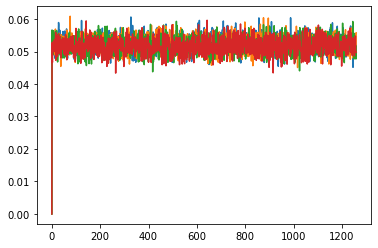

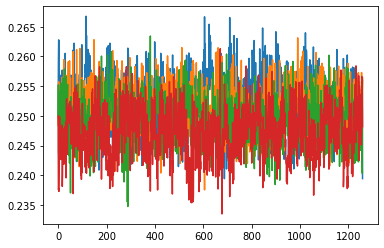

In [74]:
plt.plot(stdev_list)
plt.show()
plt.plot(mean_list)
plt.show()

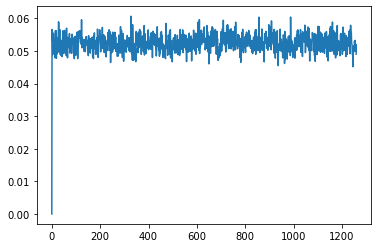

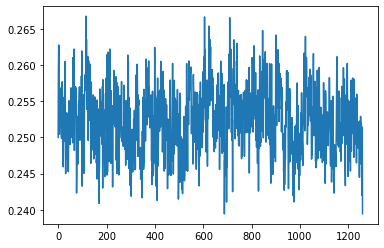

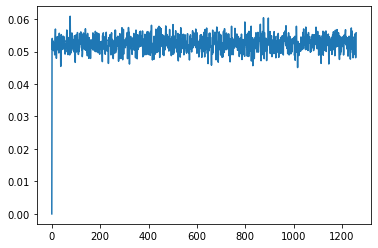

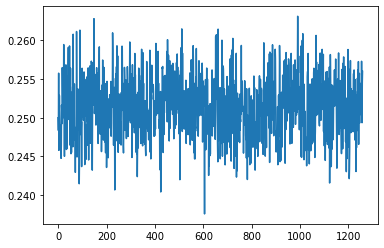

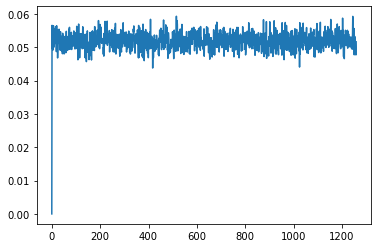

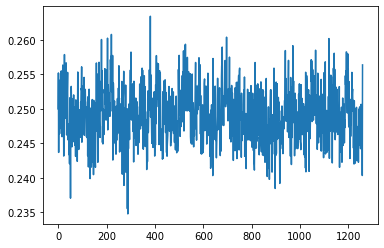

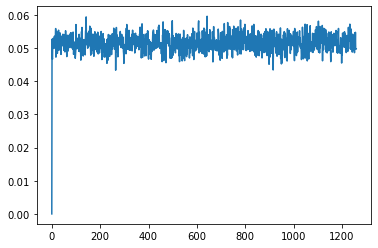

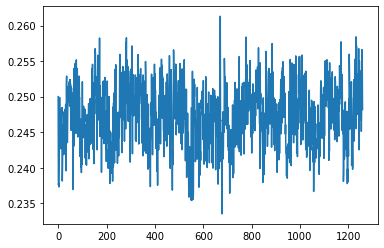

In [41]:
for i in range(4):
    plt.plot((np.array(stdev_list).T[i]))
    plt.show()
    plt.plot((np.array(mean_list).T[i]))
    plt.show()

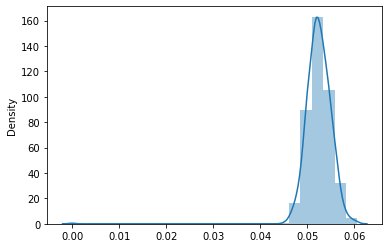

In [211]:
import seaborn as sns
for i in range(4):
#     plt.plot((np.array(stdev_list).T[i]))
    sns.distplot(np.array(stdev_list).T[i],bins=25 )
    plt.show()
    break

In [40]:
(np.array(stdev_list).T[0])

array([0.        , 0.05656691, 0.05336016, ..., 0.04989734, 0.05197915,
       0.04899609])

In [23]:
detect = []
for d in vect_dict:
    tmp = np.array(vect_dict[d]).T.tolist()
    ttt1 = []
    ttt2 = []
    for i in range(len(tmp)):
        t = tmp[i]
        stdev = statistics.stdev(t[:])
        mean = sum(t[:])/len(t[:])
        ttt1.append(stdev)#每天4股的stdev
        ttt2.append(mean) #mean
        if stdev>thresh:
            detect.append([d,org_etfs[i],stdev,mean])
print(detect)

[['2016-04-22', 'VEU', 0.060871594640017554, 0.26115582545598354], ['2016-06-29', 'ITOT', 0.059558141402889765, 0.26117290750145894], ['2016-07-27', 'AGG', 0.059432993170875886, 0.25455314326286327], ['2017-04-21', 'ITOT', 0.060640783026418246, 0.26013362706700954], ['2018-01-19', 'VNQ', 0.05930186840585151, 0.255401714026928], ['2018-06-06', 'ITOT', 0.059595596904650265, 0.2523130953609942], ['2018-07-23', 'AGG', 0.0596370167743154, 0.24865596810976662], ['2018-10-25', 'ITOT', 0.059407714766297096, 0.26655619169274974], ['2019-03-07', 'VEU', 0.059105060970986896, 0.25283278655012437], ['2019-05-30', 'ITOT', 0.06035552136549033, 0.26184842787186297], ['2019-06-26', 'VEU', 0.06039733211148238, 0.2585015905598799], ['2019-07-25', 'VEU', 0.06030880888265463, 0.254000905285279], ['2019-08-13', 'ITOT', 0.059205416574368355, 0.26213168753186855], ['2019-12-04', 'ITOT', 0.06039687225890363, 0.25257911466558763], ['2020-12-10', 'VNQ', 0.0592610779199044, 0.24999499415357912]]


In [29]:
thresh2 = mu-sig*2
print(thresh2)
detect2 = []
for d in vect_dict:
    tmp = np.array(vect_dict[d]).T.tolist()
    ttt1 = []
    ttt2 = []
    for i in range(len(tmp)):
        t = tmp[i]
        stdev = statistics.stdev(t[:])
        mean = sum(t[:])/len(t[:])
        ttt1.append(stdev)#每天4股的stdev
        ttt2.append(mean) #mean
        if stdev<thresh2:
            detect2.append([d,org_etfs[i],stdev,mean])
print(detect2)

0.046430843443709145
[['2016-01-04', 'ITOT', 0.0, 0.25], ['2016-01-04', 'VEU', 0.0, 0.25], ['2016-01-04', 'VNQ', 0.0, 0.25], ['2016-01-04', 'AGG', 0.0, 0.25], ['2016-02-26', 'VEU', 0.045428940502892826, 0.24601228661338498], ['2016-06-08', 'VNQ', 0.04623925069266164, 0.24617030517260247], ['2016-06-24', 'AGG', 0.04639216598635655, 0.2474798458317915], ['2016-07-28', 'VNQ', 0.04568552397700099, 0.24342718025048565], ['2016-08-12', 'VNQ', 0.04629041051130042, 0.241523345241944], ['2016-08-26', 'VNQ', 0.046178747147344455, 0.24225214092930164], ['2016-11-28', 'AGG', 0.04543638674803564, 0.24009835909803706], ['2016-12-05', 'AGG', 0.046411117831537625, 0.24069534836212794], ['2016-12-06', 'VEU', 0.046347868568712994, 0.2406565572023391], ['2017-01-20', 'AGG', 0.04336579645511833, 0.24211969058712324], ['2017-03-10', 'AGG', 0.04541044845811548, 0.24079319807887073], ['2017-04-12', 'VEU', 0.04614796960207942, 0.24566186301906903], ['2017-07-11', 'VNQ', 0.04597006985403985, 0.2488160443902017

In [24]:
trade_action = trade_action_list[0].reset_index()
trade_action

,date,AGG,ITOT,VEU,VNQ
0,2016-01-04,0.250000,0.250000,0.250000,0.250000
1,2016-01-05,0.322141,0.285396,0.235307,0.157157
2,2016-01-06,0.262036,0.289130,0.202274,0.246559
3,2016-01-07,0.185621,0.283280,0.296492,0.234607
4,2016-01-08,0.213917,0.230097,0.277459,0.278528
...,...,...,...,...,...
1254,2020-12-24,0.188948,0.242886,0.198974,0.369192
1255,2020-12-28,0.217669,0.213960,0.272515,0.295856
1256,2020-12-29,0.333965,0.280629,0.215935,0.169471
1257,2020-12-30,0.212165,0.272181,0.228009,0.287646


In [25]:
trade_return = pd.concat([trade_action['date'],trade_return_list[0]],axis=1)

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1258, 8)
==============DRL Strategy Stats===========


Start date,2016-01-04
End date,2020-12-30
Total months,59
,Backtest
Annual return,6.689%
Cumulative returns,38.158%
Annual volatility,14.097%
Sharpe ratio,0.53
Calmar ratio,0.23
Stability,0.69
Max drawdown,-28.841%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,28.84,2020-02-14,2020-03-23,2020-09-02,144
1,14.82,2018-01-26,2018-12-24,2019-06-18,363
2,7.20,2016-01-05,2016-02-11,2016-03-03,43
3,6.41,2020-09-02,2020-09-23,2020-11-10,50
4,6.35,2016-09-07,2016-11-03,2017-02-27,124


Stress Events,mean,min,max
New Normal,0.03%,-9.51%,6.53%


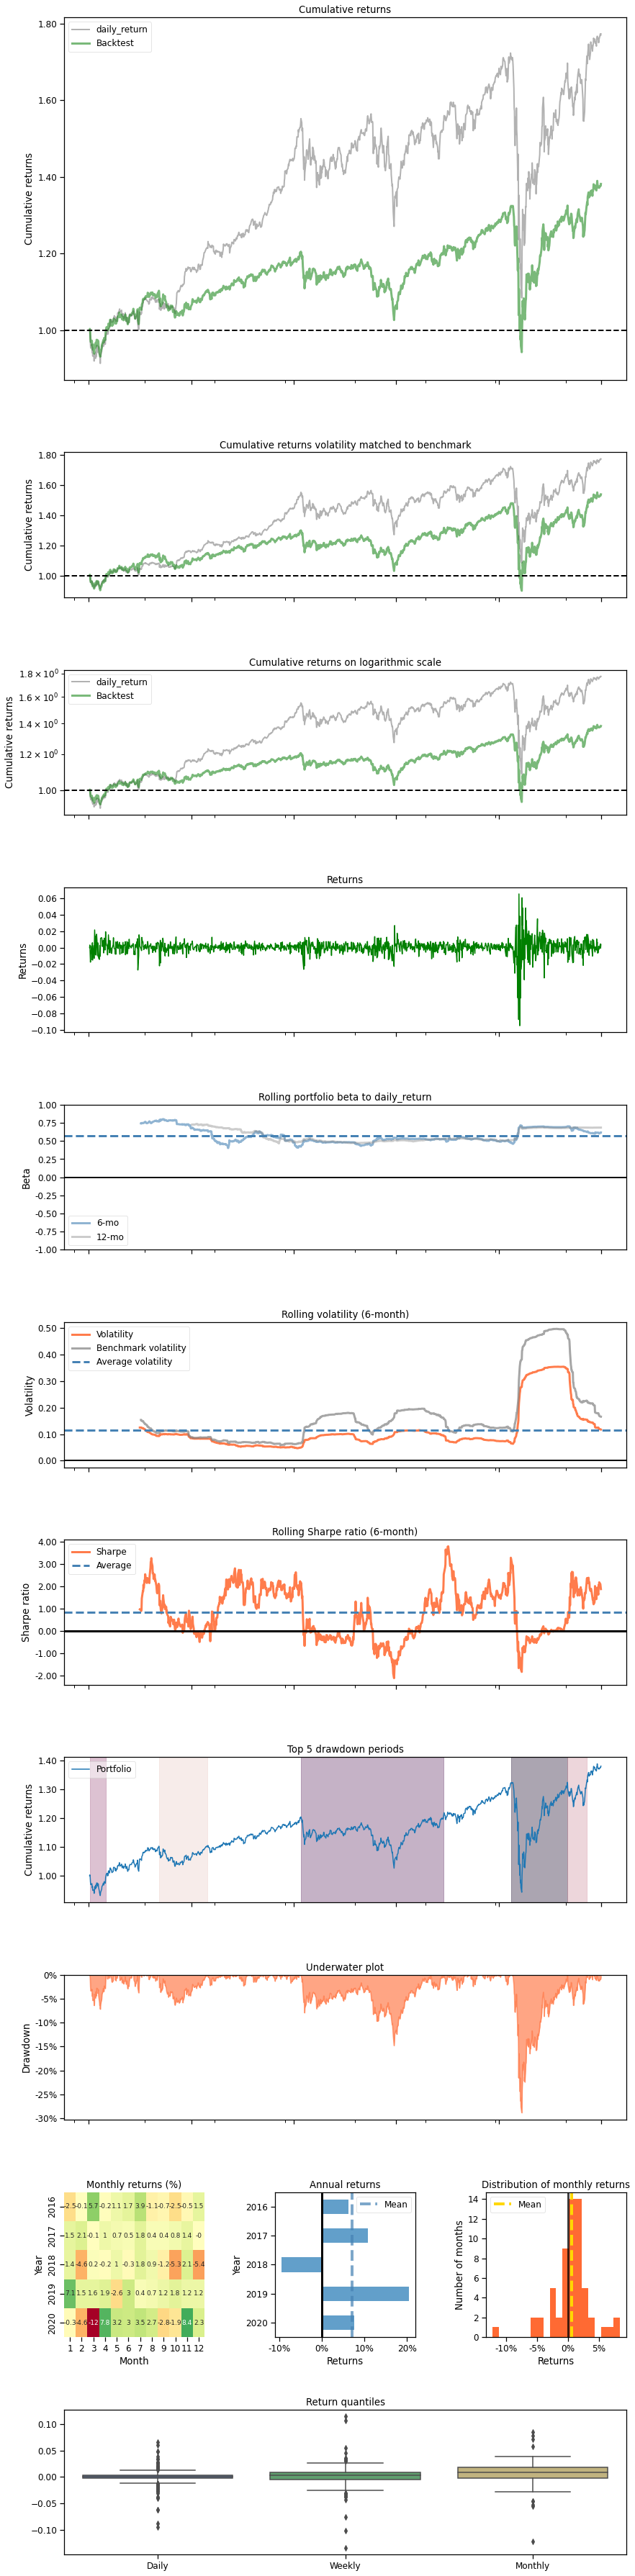

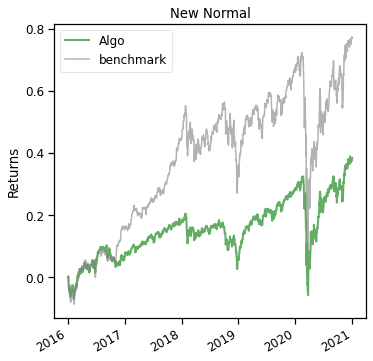

In [26]:
from pyfolio import timeseries
import pyfolio
%matplotlib inline

baseline_df = get_baseline(
        ticker="^DJI", 
        start = trade_return.loc[0,'date'],
        end = trade_return.loc[len(trade_return)-1,'date'])
baseline_returns = get_daily_return(baseline_df, value_col_name="close")

for i in range(1):
    trade_action = trade_action_list[i].reset_index()
    trade_return = pd.concat([trade_action['date'],trade_return_list[i]],axis=1)
    DRL_strat = convert_daily_return_to_pyfolio_ts(trade_return)
    perf_func = timeseries.perf_stats 
    perf_stats_all = perf_func( returns=DRL_strat, 
                              factor_returns=DRL_strat, 
                                positions=None, transactions=None, turnover_denom="AGB")
    print("==============DRL Strategy Stats===========")
#     print(perf_stats_all)
    
    with pyfolio.plotting.plotting_context(font_scale=1.1):
        pyfolio.create_full_tear_sheet(returns = DRL_strat,
                                       benchmark_rets=baseline_returns, set_context=False)

In [13]:
# final_actoin = trade_action_list[0].copy(deep=True)
df_concat = pd.concat(trade_action_list)
by_row_index = df_concat.groupby(df_concat.index)
by_row_index 

In [14]:
final_action = by_row_index.mean()
final_action

,AGG,ITOT,VEU,VNQ
date,,,,
2016-01-04,0.250000,0.250000,0.250000,0.250000
2016-01-05,0.304295,0.274034,0.167281,0.254390
2016-01-06,0.305958,0.252916,0.206141,0.234985
2016-01-07,0.333443,0.228478,0.219040,0.219040
2016-01-08,0.226474,0.176814,0.289300,0.307412
...,...,...,...,...
2020-12-24,0.246101,0.164337,0.251260,0.338302
2020-12-28,0.281581,0.200784,0.250206,0.267428
2020-12-29,0.270025,0.193443,0.183888,0.352644


In [40]:
trade_return_list[0]['daily_return']+=1
trade_return_list[0]

,date,daily_return
0,2016-01-04,1.000000
1,2016-01-05,1.003430
2,2016-01-06,0.995917
3,2016-01-07,0.983332
4,2016-01-08,0.993487
...,...,...
1254,2020-12-24,0.998498
1255,2020-12-28,1.003846
1256,2020-12-29,0.996885
1257,2020-12-30,1.003391


In [37]:
trade_return_list[0]

,date,daily_return
0,2016-01-04,0.000000
1,2016-01-05,0.003430
2,2016-01-06,-0.004083
3,2016-01-07,-0.016668
4,2016-01-08,-0.006513
...,...,...
1254,2020-12-24,-0.001502
1255,2020-12-28,0.003846
1256,2020-12-29,-0.003115
1257,2020-12-30,0.003391


In [54]:
trade_return_list[0]['daily_return']+=1
trade_return_list[1]['daily_return']+=1
trade_return_list[2]['daily_return']+=1
df_concat = pd.concat(trade_return_list)
df_concat

,date,daily_return
0,2016-01-04,1.000000
1,2016-01-05,1.003430
2,2016-01-06,0.995917
3,2016-01-07,0.983332
4,2016-01-08,0.993487
...,...,...
1254,2020-12-24,0.999947
1255,2020-12-28,1.004007
1256,2020-12-29,0.999008
1257,2020-12-30,1.003533


In [55]:
by_row_index = df_concat.groupby(df_concat.index)
final_reward = by_row_index.mean()-1
final_reward

,daily_return
0,0.000000
1,0.003611
2,-0.007534
3,-0.016609
4,-0.008002
...,...
1254,-0.000739
1255,0.003979
1256,-0.001634
1257,0.003728


In [20]:
vect_dict = {}

for j in range(len(trade_action_list[0])):
    tmp = []
    d = trade_action_list[0].reset_index()['date'][j]
    print(d)
    for i in range(250):
        trade_return_df = trade_action_list[i].reset_index().T
#         print(trade_return_df)
        vect = list(trade_return_df[j])[1:]
#         print(vect)
        tmp.append(vect)
    vect_dict[d] = tmp

2016-01-04
2016-01-05
2016-01-06
2016-01-07
2016-01-08
2016-01-11
2016-01-12
2016-01-13
2016-01-14
2016-01-15
2016-01-19
2016-01-20
2016-01-21
2016-01-22
2016-01-25
2016-01-26
2016-01-27
2016-01-28
2016-01-29
2016-02-01
2016-02-02
2016-02-03
2016-02-04
2016-02-05
2016-02-08
2016-02-09
2016-02-10
2016-02-11
2016-02-12
2016-02-16
2016-02-17
2016-02-18
2016-02-19
2016-02-22
2016-02-23
2016-02-24
2016-02-25
2016-02-26
2016-02-29
2016-03-01
2016-03-02
2016-03-03
2016-03-04
2016-03-07
2016-03-08
2016-03-09
2016-03-10
2016-03-11
2016-03-14
2016-03-15
2016-03-16
2016-03-17
2016-03-18
2016-03-21
2016-03-22
2016-03-23
2016-03-24
2016-03-28
2016-03-29
2016-03-30
2016-03-31
2016-04-01
2016-04-04
2016-04-05
2016-04-06
2016-04-07
2016-04-08
2016-04-11
2016-04-12
2016-04-13
2016-04-14
2016-04-15
2016-04-18
2016-04-19
2016-04-20
2016-04-21
2016-04-22
2016-04-25
2016-04-26
2016-04-27
2016-04-28
2016-04-29
2016-05-02
2016-05-03
2016-05-04
2016-05-05
2016-05-06
2016-05-09
2016-05-10
2016-05-11
2016-05-12

2018-12-18
2018-12-19
2018-12-20
2018-12-21
2018-12-24
2018-12-26
2018-12-27
2018-12-28
2018-12-31
2019-01-02
2019-01-03
2019-01-04
2019-01-07
2019-01-08
2019-01-09
2019-01-10
2019-01-11
2019-01-14
2019-01-15
2019-01-16
2019-01-17
2019-01-18
2019-01-22
2019-01-23
2019-01-24
2019-01-25
2019-01-28
2019-01-29
2019-01-30
2019-01-31
2019-02-01
2019-02-04
2019-02-05
2019-02-06
2019-02-07
2019-02-08
2019-02-11
2019-02-12
2019-02-13
2019-02-14
2019-02-15
2019-02-19
2019-02-20
2019-02-21
2019-02-22
2019-02-25
2019-02-26
2019-02-27
2019-02-28
2019-03-01
2019-03-04
2019-03-05
2019-03-06
2019-03-07
2019-03-08
2019-03-11
2019-03-12
2019-03-13
2019-03-14
2019-03-15
2019-03-18
2019-03-19
2019-03-20
2019-03-21
2019-03-22
2019-03-25
2019-03-26
2019-03-27
2019-03-28
2019-03-29
2019-04-01
2019-04-02
2019-04-03
2019-04-04
2019-04-05
2019-04-08
2019-04-09
2019-04-10
2019-04-11
2019-04-12
2019-04-15
2019-04-16
2019-04-17
2019-04-18
2019-04-22
2019-04-23
2019-04-24
2019-04-25
2019-04-26
2019-04-29
2019-04-30

In [66]:
df_concat = pd.concat(trade_action_list)
by_row_index = df_concat.groupby(df_concat.index)
by_row_index.mean()

,AGG,ITOT,VEU,VNQ
date,,,,
2016-01-04,0.250000,0.250000,0.250000,0.250000
2016-01-05,0.258822,0.248352,0.255214,0.237613
2016-01-06,0.262795,0.255766,0.243680,0.237760
2016-01-07,0.262744,0.245780,0.254183,0.237293
2016-01-08,0.257024,0.248905,0.253674,0.240397
...,...,...,...,...
2020-12-24,0.247672,0.257307,0.247561,0.247460
2020-12-28,0.242018,0.254472,0.246875,0.256635
2020-12-29,0.248841,0.249352,0.250471,0.251336


In [67]:
by_row_index.std()

,AGG,ITOT,VEU,VNQ
date,,,,
2016-01-04,0.000000,0.000000,0.000000,0.000000
2016-01-05,0.056567,0.050622,0.056570,0.052705
2016-01-06,0.053360,0.054051,0.049567,0.046956
2016-01-07,0.055792,0.050593,0.050993,0.046696
2016-01-08,0.048868,0.053312,0.049112,0.052514
...,...,...,...,...
2020-12-24,0.053237,0.055476,0.052005,0.051022
2020-12-28,0.049952,0.051743,0.050133,0.054789
2020-12-29,0.049897,0.048094,0.048126,0.049809


In [ ]:
stdev_dict = {}
mean_dict = {}

for d in vect_dict:
    tmp = np.array(vect_dict[d]).T.tolist()
    fig,ax=plt.subplots(1,4,figsize=(30,8))
    ttt1 = []
    ttt2 = []
    for i in range(len(tmp)):
        t = tmp[i]
        stdev = statistics.stdev(t[:])
        mean = sum(t[:])/len(t[:])
        print(stdev,mean)
        ttt1.append(stdev)#每天4股的stdev
        ttt2.append(mean) #mean
        sns.distplot(t,ax = ax[i],bins=25 )#,bins=25
    stdev_dict[d] = ttt1
    mean_dict[d] = ttt2
    plt.show()
    plt.close()

In [85]:

filename = 'us_etf.txt'

all_etf = []  
f = open(filename)
for line in f:
#     print(line[:-1])
    all_etf.append(line[:-1])
print(all_etf)

['SPY', 'IVV', 'VTI', 'VOO', 'QQQ', 'VEA', 'IEFA', 'AGG', 'VWO', 'IEMG', 'VUG', 'BND', 'IWM', 'VTV', 'IWF', 'IJR', 'GLD', 'IJH', 'EFA', 'VIG', 'LQD', 'IWD', 'VO', 'VCIT', 'VGT', 'VB', 'VXUS', 'XLK', 'BNDX', 'VCSH', 'ITOT', 'VNQ', 'VEU', 'IVW', 'VYM', 'XLF', 'EEM', 'BSV', 'IAU', 'USMV', 'ARKK', 'SCHX', 'TIP', 'IWR', 'IXUS', 'IWB', 'DIA', 'MBB', 'SCHF', 'XLV', 'IGSB', 'VV', 'HYG', 'MUB', 'VBR', 'RSP', 'QUAL', 'MDY', 'XLY', 'IVE', 'SCHB', 'XLE', 'SHY', 'VT', 'EMB', 'PFF', 'SCHD', 'SDY', 'SLV', 'SHV', 'VBK', 'MTUM', 'IWP', 'XLI', 'JPST', 'DGRO', 'VXF', 'DVY', 'SCHP', 'SCHA', 'BIV', 'VGK', 'ACWI', 'GOVT', 'MINT', 'TLT', 'ESGU', 'GDX', 'IEF', 'VHT', 'IWN', 'EWJ', 'VMBS', 'SCHG', 'IWO', 'XLC', 'ARKG', 'SCZ', 'BIL', 'GSLC', 'IWS', 'VOE', 'VLUE', 'EFV', 'XLU', 'VTEB', 'IBB', 'IEI', 'FDN', 'VTIP', 'IGIB', 'IWV', 'TQQQ', 'VOT', 'IUSG', 'XLP', 'JNK', 'EFG', 'MGK', 'FVD', 'IUSB', 'SPDW', 'SPYG', 'EFAV', 'VGSH', 'SCHE', 'ARKW', 'IHI', 'SCHZ', 'SCHM', 'SPLG', 'SCHV', 'BBJP', 'SPLV', 'SPYV', 'VFH', 'X

In [101]:
import pandas as pd
import yfinance as yf
df_ttt = yf.download(['SPY'],start='2011-01-01',end='2016-01-01')
df_ttt

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-12-31,125.529999,125.870003,125.330002,125.750000,101.698303,91218900
2011-01-03,126.709999,127.599998,125.699997,127.050003,102.749626,138725200
2011-01-04,127.330002,127.370003,126.190002,126.980003,102.693031,137409700
2011-01-05,126.580002,127.720001,126.459999,127.639999,103.226822,133975300
2011-01-06,127.690002,127.830002,127.010002,127.389999,103.024628,122519000
...,...,...,...,...,...,...
2015-12-24,205.720001,206.330002,205.419998,205.679993,184.288116,48539600
2015-12-28,204.860001,205.259995,203.940002,205.210007,183.866989,65899900
2015-12-29,206.509995,207.789993,206.470001,207.399994,185.829208,92640700


In [102]:
df_ttt = pd.DataFrame(df_ttt['Close'])
df_ttt = df_ttt.reset_index()
df_ttt

,Date,Close
0,2010-12-31,125.750000
1,2011-01-03,127.050003
2,2011-01-04,126.980003
3,2011-01-05,127.639999
4,2011-01-06,127.389999
...,...,...
1254,2015-12-24,205.679993
1255,2015-12-28,205.210007
1256,2015-12-29,207.399994
1257,2015-12-30,205.929993


In [104]:

df_ttt['day_return'] = 0 
for i in range(len(df_ttt)-1):
    df_ttt.loc[i+1,'day_return'] = (df_ttt['Close'][i+1] - df_ttt['Close'][i])/df_ttt['Close'][i]
# print(df2)
df_ttt = df_ttt.fillna(0)
df_ttt['max']=0
s1 = df_ttt['Close']
for i in range(len(df_ttt)):
    df_ttt.loc[i,'max'] = s1[0:i+1].max() 
    
df_ttt['dd'] = 0
df_ttt['dd'] = 1-(df_ttt['Close']/df_ttt['max'])
    
mdd = df_ttt['dd'].max()
print(mdd)
df_ttt

0.1942387582881523


,Date,Close,day_return,max,dd
0,2010-12-31,125.750000,0.000000,125.750000,0.000000
1,2011-01-03,127.050003,0.010338,127.050003,0.000000
2,2011-01-04,126.980003,-0.000551,127.050003,0.000551
3,2011-01-05,127.639999,0.005198,127.639999,0.000000
4,2011-01-06,127.389999,-0.001959,127.639999,0.001959
...,...,...,...,...,...
1254,2015-12-24,205.679993,-0.001650,213.500000,0.036628
1255,2015-12-28,205.210007,-0.002285,213.500000,0.038829
1256,2015-12-29,207.399994,0.010672,213.500000,0.028571
1257,2015-12-30,205.929993,-0.007088,213.500000,0.035457


In [105]:
import math
df_ttt['total_value'] = 1000000
for i in range(1,len(df_ttt)):
    df_ttt.loc[i,'total_value'] = df_ttt['total_value'][i-1]*(df_ttt['day_return'][i]+1)
    
# df_ttt['all_return'] = 0
# for i in range(len(df_ttt)):
#     df_ttt.loc[i,'all_return'] = (df_ttt['total_value'][i]-df_ttt['total_value'][0])/df_ttt['total_value'][0]
stdev_ttt = statistics.stdev(df_ttt['day_return'])* math.pow( 252, 0.5 )
print(stdev_ttt)
reward_ttt = (df_ttt['total_value'][len(df_ttt)-1]-df_ttt['total_value'][0])/df_ttt['total_value'][0]
print(reward_ttt)
df_ttt

0.15393572839450395
0.6212325655442404


,Date,Close,day_return,max,dd,total_value
0,2010-12-31,125.750000,0.000000,125.750000,0.000000,1.000000e+06
1,2011-01-03,127.050003,0.010338,127.050003,0.000000,1.010338e+06
2,2011-01-04,126.980003,-0.000551,127.050003,0.000551,1.009781e+06
3,2011-01-05,127.639999,0.005198,127.639999,0.000000,1.015030e+06
4,2011-01-06,127.389999,-0.001959,127.639999,0.001959,1.013042e+06
...,...,...,...,...,...,...
1254,2015-12-24,205.679993,-0.001650,213.500000,0.036628,1.635626e+06
1255,2015-12-28,205.210007,-0.002285,213.500000,0.038829,1.631889e+06
1256,2015-12-29,207.399994,0.010672,213.500000,0.028571,1.649304e+06
1257,2015-12-30,205.929993,-0.007088,213.500000,0.035457,1.637614e+06


In [258]:
def get_ABC(etf_name,start,end):
#     df_ttt = yf.download([etf_name],start=start,end=end)
#     df_ttt = pd.DataFrame(df_ttt['Close'])
#     df_ttt = df_ttt.reset_index()
    df_ttt['day_return'] = 0 
    for i in range(len(df_ttt)-1):
        df_ttt.loc[i+1,'day_return'] = (df_ttt['Close'][i+1] - df_ttt['Close'][i])/df_ttt['Close'][i]

    df_ttt = df_ttt.fillna(0)
    df_ttt['max']=0
    s1 = df_ttt['Close']
    for i in range(len(df_ttt)):
        df_ttt.loc[i,'max'] = s1[0:i+1].max() 
    
    df_ttt['dd'] = 0
    df_ttt['dd'] = 1-(df_ttt['Close']/df_ttt['max'])
    
    mdd = df_ttt['dd'].max()
    # print(mdd)
    df_ttt['total_value'] = 1000000
    for i in range(1,len(df_ttt)):
        df_ttt.loc[i,'total_value'] = df_ttt['total_value'][i-1]*(df_ttt['day_return'][i]+1)
    # print(df_ttt)
    stdev_ttt = statistics.stdev(df_ttt['day_return'])* math.pow( 252, 0.5 )
    # print(stdev_ttt)
#     reward_ttt = ((df_ttt['total_value'][len(df_ttt)-1]-df_ttt['total_value'][0])/df_ttt['total_value'][0])
    reward_ttt = (df_ttt['total_value'][len(df_ttt)-1]/df_ttt['total_value'][0])**(252/lendf_ttt)-1
    # print(reward_ttt)
    return reward_ttt,stdev_ttt,mdd

In [115]:
record_ABC_train = {}
for etf_name in all_etf:
    reward_ttt,stdev_ttt,mdd = get_ABC(etf_name,'2011-01-01','2016-01-01')
    record_ABC_train[etf_name] = [reward_ttt,stdev_ttt,mdd]
    break
# record_ABC_test = {}
# for etf_name in all_etf:
#     reward_ttt,stdev_ttt,mdd = get_ABC(etf_name,'2011-01-01','2016-01-01')
#     record_ABC_test[etf_name] = [reward_ttt,stdev_ttt,mdd]
print(reward_ttt,stdev_ttt,mdd)

[*********************100%***********************]  1 of 1 completed
0.6212325655442404 0.15393572839450395 0.1942387582881523


In [119]:
    

record_ABC_train = {}
record_ABC_test = {}

for etf_name in all_etf1:
    if etf_name[-3:]=='.TW':
        continue
    if etf_name in record_ABC_train:
        continue
    try:
        df_ttt = yf.download([etf_name],start='2011-01-01',end='2021-01-01')
        df_ttt = pd.DataFrame(df_ttt['Close'])
        df_ttt = df_ttt.reset_index()
        df_train = df_ttt[df_ttt['Date']<'2016-01-01']
        df_test = df_ttt[df_ttt['Date']>'2016-01-01']
        df_test = df_test.reset_index()
    
        reward_ttt,stdev_ttt,mdd = get_ABC(df_train)
        record_ABC_train[etf_name] = [reward_ttt,stdev_ttt,mdd]
        print(etf_name,'train',reward_ttt,stdev_ttt,mdd)

        reward_ttt,stdev_ttt,mdd = get_ABC(df_test)
        record_ABC_test[etf_name] = [reward_ttt,stdev_ttt,mdd]
        print(etf_name,'test',reward_ttt,stdev_ttt,mdd)
    except:
        continue

[*********************100%***********************]  1 of 1 completed
SPY train 0.6212325655442404 0.15393572839450395 0.1942387582881523
SPY test 0.8599144211342169 0.18929337875512423 0.3410474689324394
[*********************100%***********************]  1 of 1 completed
IVV train 0.622732634591592 0.15452502509488142 0.1948298512451947
IVV test 0.8583664091506822 0.19288700173559578 0.3390314503086417
[*********************100%***********************]  1 of 1 completed
VTI train 0.6063453343837946 0.15796078084761328 0.21060815017929613
VTI test 0.8944909814747686 0.19219090301188577 0.3500028759232755
[*********************100%***********************]  1 of 1 completed
VOO train 0.6235017688612743 0.15380951079146038 0.1959936387479333
VOO test 0.8647387933047146 0.1919550075981344 0.34301429483265344
[*********************100%***********************]  1 of 1 completed
QQQ train 1.053984621572357 0.17071444741715971 0.16099282436457274
QQQ test 1.8652053902682788 0.22022257217276864

[*********************100%***********************]  1 of 1 completed
ARKK train 0.003925413493640954 0.1863442386282305 0.16644169733611258
ARKK test 5.221389127426612 0.314356036106652 0.42537685538392045
[*********************100%***********************]  1 of 1 completed
SCHX train 0.6211615880855168 0.15402188772122674 0.2003071798229582
SCHX test 0.9007314492900325 0.1917880147939907 0.3433296324068589
[*********************100%***********************]  1 of 1 completed
TIP train 0.02008932040129916 0.05613054550196681 0.11832930743043613
TIP test 0.15929525763601343 0.052549613090260704 0.11204507307290079
[*********************100%***********************]  1 of 1 completed
IWR train 0.5742505422681177 0.16773063068384164 0.245456129247275
IWR test 0.732701498938583 0.20488762769724259 0.4059070058554003
[*********************100%***********************]  1 of 1 completed
IXUS train 0.022314007898946643 0.1380814870948306 0.21446178412988104
IXUS test 0.3842192248478839 0.1832173

StatisticsError: variance requires at least two data points

In [127]:
for etf_name in all_etf1:
    if etf_name[-3:]=='.TW':
        continue
    if etf_name in record_ABC_train:
        continue
    try:
        df_ttt = yf.download([etf_name],start='2011-01-01',end='2021-01-01')
        df_ttt = pd.DataFrame(df_ttt['Close'])
        df_ttt = df_ttt.reset_index()
        df_train = df_ttt[df_ttt['Date']<'2016-01-01']
        df_test = df_ttt[df_ttt['Date']>'2016-01-01']
        df_test = df_test.reset_index()
    
        reward_ttt,stdev_ttt,mdd = get_ABC(df_train)
        record_ABC_train[etf_name] = [reward_ttt,stdev_ttt,mdd]
        print(etf_name,'train',reward_ttt,stdev_ttt,mdd)

        reward_ttt,stdev_ttt,mdd = get_ABC(df_test)
        record_ABC_test[etf_name] = [reward_ttt,stdev_ttt,mdd]
        print(etf_name,'test',reward_ttt,stdev_ttt,mdd)
    except:
        continue

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
DGRO train 0.04092383372742578 0.13317086138476297 0.12069604595544992
DGRO test 0.7708415899073761 0.1918892605473649 0.35103178581160843
[*********************100%***********************]  1 of 1 completed
VXF train 0.540158119587715 0.18599828634423096 0.27641333689128633
VXF test 1.0002427913667822 0.22043347664507168 0.4171626376817492
[*********************100%***********************]  1 of 1 completed
DVY train 0.5072202287594217 0.13443167762723485 0.16145646233063693
DVY test 0.28996785749077447 0.20345404614945764 0.41593665995782436
[*********************100%***********************]  1 of 1 completed
SCHP train 0.052079229071583834 0.05476852887419775 0.11831220795836628
SCHP test 0.16538391773200664 0.05031168076519398 0.10848025469750666
[*********************100%***********************]  1 of 1 completed
SCHA train 0.5186589303566376 0.

XLP test 0.3530591577301205 0.16195152549612135 0.249421201096777
[*********************100%***********************]  1 of 1 completed
JNK train -0.14605887935571826 0.07886801192420617 0.20314733445071842
JNK test 0.07626952309425594 0.09476283888608411 0.24665955740677525
[*********************100%***********************]  1 of 1 completed
EFG train 0.09921410243823425 0.18509995873628488 0.267711719735085
EFG test 0.527088390828188 0.17470342574695558 0.29881558062617486
[*********************100%***********************]  1 of 1 completed
MGK train 0.7552314205259663 0.1563719129986605 0.1719421489759274
MGK test 1.4969363212012643 0.2082124005158696 0.3122763777951776
[*********************100%***********************]  1 of 1 completed
FVD train 0.5825048985616768 0.13211424607140657 0.15951658678851566
FVD test 0.4860169122014367 0.17779382722028067 0.3524946185152864
[*********************100%***********************]  1 of 1 completed
IUSB train -0.009883177417049766 0.0387405967

[*********************100%***********************]  1 of 1 completed
IJT train 0.712494886760402 0.19421917379293296 0.2658834449451648
IJT test 0.8921202750096715 0.24093981892465688 0.4286124508561474
[*********************100%***********************]  1 of 1 completed
ICLN train -0.3787878751389852 0.26347202777084255 0.6726790476694477
ICLN test 1.896410232935186 0.2510723096600125 0.41502808584301265
[*********************100%***********************]  1 of 1 completed
EWT train -0.18245835138771357 0.20400306449296968 0.30136982315457184
EWT test 1.1437803449265984 0.20499695136726342 0.29490555910221317
[*********************100%***********************]  1 of 1 completed
EWZ train -0.7328165387921687 0.2907128510198087 0.741288547186534
EWZ test 0.8590771665982916 0.4069040636990776 0.5699235744588169
[*********************100%***********************]  1 of 1 completed
VSS train -0.067757476549873 0.17976591984628842 0.29128569818818606
VSS test 0.32564455971314527 0.183303191077

TAN test 2.339616529329723 0.336558419075188 0.46918301506522897
[*********************100%***********************]  1 of 1 completed
KWEB train 0.462176471984297 0.29743416569138503 0.3691410839985384
KWEB test 1.0926557175134206 0.28931325870967056 0.47029554136998664
[*********************100%***********************]  1 of 1 completed
EZU train -0.00652110970374709 0.2483638524953527 0.4025819106571128
EZU test 0.2787931613004906 0.21675499278615631 0.4478879241795931
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
SHYG train -0.10815144187609689 0.04118228947663044 0.13528370996196992
SHYG test 0.024115386986303725 0.07415334744602614 0.2184051245133739
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
NEAR train 0.0006000955849080347 0.007278078280517426 0.007357381981430655
NEAR test 0.004806686607291922 

STIP test 0.054955071813344254 0.022173211196677433 0.05288933992734213
[*********************100%***********************]  1 of 1 completed
VOX train 0.27853126883590573 0.1543957754255836 0.1975308809941111
VOX test 0.4530947192268425 0.20488918189409172 0.3365024665299047
[*********************100%***********************]  1 of 1 completed
IWY train 0.788840640481679 0.15089196320235995 0.16063764385952417
IWY test 1.5326479417046337 0.20228509116428867 0.30756902987811663
[*********************100%***********************]  1 of 1 completed
CIBR train -0.1128871217385726 0.21370034073879657 0.1868574434554866
CIBR test 1.5374500656884764 0.22141697473158584 0.3304720764034069
[*********************100%***********************]  1 of 1 completed
USO train -0.7179487179487175 0.29378878251608626 0.7638981287453102
USO test -0.6242030999801629 0.42998025225094366 0.8675373056873744
[*********************100%***********************]  1 of 1 completed
QTEC train 0.6588877107987497 0.19546

/home/alia880801/anaconda3/envs/aa/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  import sys


XT test 1.3513946805949146 0.19441575467454458 0.32214247377738003
[*********************100%***********************]  1 of 1 completed
HYD train 0.08312868863058975 0.07633185890626752 0.1766985092331924
HYD test -0.007099042109688162 0.1665444808929757 0.3580284324720139
[*********************100%***********************]  1 of 1 completed
IGM train 0.8311000999898682 0.17452424517697207 0.20312265087049342
IGM test 2.2304920455689468 0.2314610994705519 0.3018225704401102
[*********************100%***********************]  1 of 1 completed
TFI train 0.12713823886726097 0.04456284362016609 0.12080001831054688
TFI test 0.0791530085758532 0.056660648964557365 0.15487314294528387
[*********************100%***********************]  1 of 1 completed
QCLN train -0.022533546742642997 0.2829368478406339 0.5515350653606765
QCLN test 3.4281213667848736 0.2892625061306122 0.4503375105759445
[*********************100%***********************]  1 of 1 completed
[*********************100%************

[*********************100%***********************]  1 of 1 completed
TECL train 2.202637129452994 0.502265616567065 0.531035669047331
TECL test 10.648424001960366 0.6958379765054877 0.7509586740761844
[*********************100%***********************]  1 of 1 completed
MJ train -0.04520654147739976 0.1116256498606103 0.045206541477399886
MJ test -0.41428569871552046 0.38516485931423594 0.7884212802465105
[*********************100%***********************]  1 of 1 completed
ICF train 0.5100425444378546 0.19002851118359237 0.235940375772132
ICF test 0.10049023847311944 0.22378030911245853 0.4022386098113153
[*********************100%***********************]  1 of 1 completed
FMB train 0.037088668774904104 0.04295028204549179 0.03163712233262006
FMB test 0.09222181444310071 0.053062469966178805 0.139240542581478
[*********************100%***********************]  1 of 1 completed
HYS train -0.08471524332471844 0.046352096072155256 0.15627618138663735
HYS test 0.07391211681498656 0.07714934

MDYV test 0.47940826077459847 0.23930076848271703 0.4639956534068358
[*********************100%***********************]  1 of 1 completed
GNR train -0.4580449312475361 0.2042808844574426 0.517701883074319
GNR test 0.41172760872172776 0.23969943220950593 0.5218620395286311
[*********************100%***********************]  1 of 1 completed
BSCN train -0.004495512014488573 0.060848359360585955 0.05946201968502551
BSCN test 0.09445274203047785 0.05441652604133902 0.15791889991995633
[*********************100%***********************]  1 of 1 completed
JKH train 0.6046138752916556 0.1821320091814848 0.257831528609886
JKH test -0.574397981781139 0.4251760431666671 0.8537716183752345
[*********************100%***********************]  1 of 1 completed
AOR train 0.23272035318725184 0.09713596587317176 0.13790010673849207
AOR test 0.35690145844984544 0.1095750409397261 0.22949481204286448
[*********************100%***********************]  1 of 1 completed
USRT train 0.40361803433136456 0.1738

FPXI test 1.5981874713411521 0.19829710653169907 0.2699073991085441
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
PXF train -0.08145138535653892 0.20289789289884805 0.33188770736701523
PXF test 0.19046274362431653 0.200874939849415 0.45930950373108903
[*********************100%***********************]  1 of 1 completed
CXSE train -0.013676594699932728 0.23002165651313777 0.41880605715729435
CXSE test 1.682299976150367 0.2446281236071106 0.39301581315952705
[*********************100%***********************]  1 of 1 completed
PKW train 0.8692434068635037 0.1473913854633397 0.1794872201100256
PKW test 0.6370535175639118 0.21933005744300432 0.413221954684593
[*********************100%***********************]  1 of 1 completed
SDOG train 0.38758774678183605 0.12643747203599007 0.14907785753943048
SDOG test 0.2624433998618266 0.22446

REGL test 0.6315516236218244 0.20190595548441362 0.36366013466255165
[*********************100%***********************]  1 of 1 completed
SPLB train 0.05413745654494781 0.1026088061059513 0.16580912921928126
SPLB test 0.32258917851983687 0.13070346674774908 0.2795202959604445
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
GLTR train -0.40848416274948196 0.21383205677913458 0.5570423865279737
GLTR test 0.8808210568386217 0.16827477638523203 0.23293779914769097
[*********************100%***********************]  1 of 1 completed
QUS train 0.006004012939433101 0.165262918247145 0.10900535529883393
QUS test 0.7984162669355609 0.18423638610082302 0.33776568865874745
[*********************100%***********************]  1 of 1 completed
IWL train 0.6276411608069227 0.14793927772013885 0.18332800603723676
IWL test 0.9619730555716611 0.1906616978540906 0.32713796710881005
[*********************100%********

[*********************100%***********************]  1 of 1 completed
LVHD train -0.015451639983559376 0.1416166196717336 0.015451639983559362
LVHD test 0.32800983635777353 0.1779693847204844 0.3733756831177455
[*********************100%***********************]  1 of 1 completed
UYG train 1.1391988186965607 0.38398337608973293 0.5569336373313236
UYG test 0.8578748277293118 0.4577916260995526 0.6998439393871243
[*********************100%***********************]  1 of 1 completed
PWV train 0.5698866203255395 0.1479138802256199 0.1829745437083765
PWV test 0.3430861234038076 0.19753363698185716 0.3830798965100235
[*********************100%***********************]  1 of 1 completed
EWS train -0.2577617725754691 0.18272501200828042 0.32130697400818675
EWS test 0.06865667336199711 0.194759939998527 0.45760909286324825
[*********************100%***********************]  1 of 1 completed
KSA train -0.05868636827618815 0.20292324315780216 0.11131862126554748
KSA test 0.32214193380827805 0.2427712

[*********************100%***********************]  1 of 1 completed
JKF train 0.3734252278309227 0.15467891769858902 0.2215133940130395
JKF test -0.3061804695991287 0.29352998277512155 0.6152507987781055
[*********************100%***********************]  1 of 1 completed
DIV train -0.053380796069515055 0.1134134989203454 0.23523484902695135
DIV test -0.2935010435236172 0.215912846038808 0.5680587852800483
[*********************100%***********************]  1 of 1 completed
DWAS train 0.5009979887940804 0.19777440664671678 0.19946938351141696
DWAS test 1.076965542497306 0.25939074918808247 0.46164197948650354
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
DJP train -0.5629071705981253 0.14732266606362013 0.6076068553362809
DJP test 0.028651887119373422 0.1499343020268321 0.3835669884896562
[*********************100%************

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
SOCL train 0.3344526783804775 0.24029266936402693 0.28439964320377065
SOCL test 2.2010363327199007 0.24560523725804193 0.34985797565744436
[*********************100%***********************]  1 of 1 completed
RAVI train 0.00039961075554438867 0.008460930202813103 0.010026413003064394
RAVI test 0.017883308854041154 0.013585818613600554 0.037596958351850174
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
IYZ train 0.23192126151724066 0.16904317687319112 0.23625729263420614
IYZ test 0.0739161325096318 0.20292625974140527 0.3801313888608755
[*********************100%***********************]  1 of 1 completed
FGD train -0.0806928534

IGE test -0.1711743558948254 0.2773348666513088 0.6338065202440684
[*********************100%***********************]  1 of 1 completed
EMHY train -0.0806122604681506 0.08251646283189928 0.20969462779269776
EMHY test 0.032064097786721424 0.12170684060536735 0.34625929944498623
[*********************100%***********************]  1 of 1 completed
FNI train 0.1334932090919055 0.23246228676611058 0.36648648923581784
FNI test 1.1628162285360302 0.2271131340246363 0.353075202018192
[*********************100%***********************]  1 of 1 completed
HAUZ train -0.12170787318673311 0.17465883365335644 0.2632120877469408
HAUZ test 0.24152339478633483 0.18462324974540087 0.416720284014634
[*********************100%***********************]  1 of 1 completed
PALL train -0.3216879820318519 0.27520919565775676 0.42270145866924824
PALL test 3.409527305090844 0.3277480991497865 0.45648903374917993
[*********************100%***********************]  1 of 1 completed
DNL train -0.16460598625202383 0.19

ONEO test 0.4332208930392962 0.20336854360770684 0.4122796138230851
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
MORT train -0.21786138471375568 0.16370311123973025 0.3726998868225626
MORT test -0.14278407291732867 0.3362169783285765 0.7123023544022901
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
SMIN train 0.30254402242892564 0.26805562539217365 0.449031806309275
SMIN test 0.2697268937859265 0.2638763703735717 0.6173960448232126
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
IYLD train -0.07142853337293212 0.0648950101987724 0.16987290480689254
IYLD test 0.04019016118003044 0.1117353193331042 0.30379747483719133
[*********************100%***********************]  1 of 1 completed
[*********************100%*******

[*********************100%***********************]  1 of 1 completed
FAD train 0.6425503954014953 0.17640284648911805 0.24875328554648257
FAD test 1.1433588610469065 0.21163347280861555 0.37249247233072913
[*********************100%***********************]  1 of 1 completed
KBWP train 0.8788116308300576 0.13136581340715905 0.19716731357515405
KBWP test 0.46429331364492676 0.22565949179554065 0.4031110148301509
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
DBB train -0.5137126497733211 0.1932623199386456 0.5568581443935205
DBB test 0.48921484052163783 0.16302780632902023 0.40020107233464086
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
PRN train 0.5189097530370204 0.20071793885241224 0.3084455272208063
PRN test 1.133578144034638 0.22057341367538957 0.3626936068037142
[*********************100%*************

[*********************100%***********************]  1 of 1 completed
DGRS train 0.059928084652439456 0.14938306064154488 0.15465610233581484
DGRS test 0.5205689692053094 0.26288340419697237 0.4569433412369682
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
IDOG train -0.06528667365471355 0.15135771191617267 0.29271319485449976
IDOG test 0.12548678242921713 0.1985992920350096 0.4329692260874287
[*********************100%***********************]  1 of 1 completed
USCI train -0.37255812060925503 0.12347076204104895 0.45794520965994223
USCI test -0.18508361076081345 0.12180708616689968 0.45824124244171993
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
IEZ train -0.3650399334841323 0.29320062526530966 0.551599589437776
IEZ test -0.6893311311136106 0.45615783285106687 0.8907527744144431
[*********************100%*

In [124]:
for etf_name in all_etf2:
    if etf_name[-3:]=='.TW':
        continue
    try:
        df_ttt = yf.download([etf_name],start='2011-01-01',end='2021-01-01')
        df_ttt = pd.DataFrame(df_ttt['Close'])
        df_ttt = df_ttt.reset_index()
        df_train = df_ttt[df_ttt['Date']<'2016-01-01']
        df_test = df_ttt[df_ttt['Date']>'2016-01-01']
        df_test = df_test.reset_index()
    
        reward_ttt,stdev_ttt,mdd = get_ABC(df_train)
        record_ABC_train[etf_name] = [reward_ttt,stdev_ttt,mdd]
        print(etf_name,'train',reward_ttt,stdev_ttt,mdd)

        reward_ttt,stdev_ttt,mdd = get_ABC(df_test)
        record_ABC_test[etf_name] = [reward_ttt,stdev_ttt,mdd]
        print(etf_name,'test',reward_ttt,stdev_ttt,mdd)
    except:
        continue

[*********************100%***********************]  1 of 1 completed
RJI train -0.4989177241201778 0.154339936793396 0.569523811340332
RJI test 0.08078600255950634 0.17032270937897773 0.44387756508786536
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
INDL train -0.7321535092104193 0.7076446631880107 0.8560959008703005
INDL test -0.1287939402378348 0.6956533728134833 0.9202212326180811
[*********************100%***********************]  1 of 1 completed
DBEM train -0.2754656750570334 0.19137986204675042 0.31384013086865714
DBEM test 0.5422494779874144 0.17224008076800373 0.343465011891942
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
HYZD train -0.123199996948243 0.08198670018299989 0.15707617091890969
HYZD test -0.010430818602927145 0.108

HYLD test -0.018763418471139857 0.11680965630204988 0.35395373155981713
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
SRTY train -0.9363438992618324 0.5993831353299384 0.9640654499685337
SRTY test -0.9722310884136612 0.6812490750915053 0.9821810787671232
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
QABA train 0.556087853470545 0.2075303740657399 0.27995350773160266
QABA test 0.1847049318109015 0.3030073907743555 0.5102845454216735
[*********************100%*********

[*********************100%***********************]  1 of 1 completed
DRN train 1.6592750249042958 0.553731889879327 0.600071861971648
DRN test -0.30537607416530616 0.6460124615420212 0.8631813069645384
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
EWUS train 0.5132032983336438 0.18093037830249795 0.22028980132783793
EWUS test 0.08309817194901453 0.24229921394787052 0.5059978108545737
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
PBS train 0.8060344290128559 0.1896036160185857 0.27976952097158536
PBS test 0.8862519421748791 0.21700985638885317 0.4063634002014347
[*********************100%***********************]  1 of 1 completed
XMVM train 0.5693477356878703 0.17490432879427711 0.26036868080917286
XMVM test 0.4948918209037783 0.235229662

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
PSCE train -0.541877787329997 0.36250770410400807 0.7324279780767975
PSCE test -0.7171391922034674 0.4856127542528101 0.9078887390416603
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
DRW train -0.08767021987806575 0.19625466695045402 0.2955292488024679
DRW test 0.001170912502508727 0.18543518284171667 0.44731556164213127
[*********************100%***********************]  1 of 1 completed
SCJ train 0.2526789745838712 0.1861801111519569 0.19374366542756372
SCJ test 0.3724162333690943 0.17207869440746762 0.408472199890492
[*********************100%***********

QWLD test 0.5883585001713256 0.16914302303190876 0.3189074253026811
[*********************100%***********************]  1 of 1 completed
BRF train -0.8200416078446259 0.2835100249024101 0.8301319482590179
BRF test 1.136409093939593 0.36569462087270693 0.6042988064016214
[*********************100%***********************]  1 of 1 completed
IPFF train -0.3486183469624792 0.12359349708494828 0.44480996924260974
IPFF test -0.019509151222076734 0.1761470577570977 0.5668016032153109
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
UCIB train -0.1354610460575982 0.1379840227060116 0.15886529533263682
UCIB test 0.2572255006691902 0.1823013028741796 0.3693693285475821
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
PVI train -0.003201277488543419 0.005815883361779794 0.006794567273526786
PVI test -0.0012043631806268823 

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
GYLD train -0.31442271767224766 0.11671207115848488 0.40366974144186674
GYLD test -0.2285714381042039 0.19464564031436296 0.5696908277699914
[*********************100%***********************]  1 of 1 completed
PSCC train 0.8603863470033987 0.17127656740046196 0.17430097826223856
PSCC test 0.6342471584407934 0.20018589851612578 0.35396789759673186
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%****

[*********************100%***********************]  1 of 1 completed
UBT train 0.8532761041874631 0.29790029542178975 0.3840088563765742
UBT test 0.6542516634747679 0.270310357984166 0.3809116756685791
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
ALFA train 0.505622580434392 0.1537022947751982 0.22338831895380062
ALFA test 1.0952770341797065 0.21603810581142444 0.39622941646590093
[*********************100%***********************]  1 of 1 completed
BBP train 0.18310942792572268 0.2958355149167284 0.2898242089177743
BBP test 0.7873697771676071 0.29442612711845617 0.32246252182525503
[*********************100%***********************]  1 of 1 completed
JHMF train 0.07815056488032732 0.18020176866596913 0.06088559392266657
JHMF test 0.6498608393866059 0.245105571

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
ICOL train -0.5632231668764488 0.2681440566752897 0.6845567894249402
ICOL test 0.10291256760324188 0.2761215635728671 0.6545012382103177
[*********************100%*********

/home/alia880801/anaconda3/envs/aa/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  import sys


TUSA test 0.6558985540420322 0.22348703796493966 0.42471545357575646
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
SYE train 0.17688162474269584 0.12046052582951984 0.11187018220800615
SYE test 0.7097295859385864 0.1876763214393596 0.35393590038893463
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
SYG train 0.20253085168703436 0.137

FCA test 0.4631418695992145 0.25488477082369637 0.4384392727731373
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
DBEZ train 0.0966254600464201 0.21629357995390636 0.20989257896752422
DBEZ test 0.26857579666128706 0.20889172337778067 0.38762977725380077
[*********************100%***********************]  1 of 1 completed
KFYP train 0.2455795604179832 0.32

REK test -0.4169647406571141 0.21794925205508056 0.47886029258692653
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
BIS train -0.9717421268853617 0.4777350903089902 0.9782901737564195
BIS test -0.8073649631472765 0.509311302658388 0.8961691645711635
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%************

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
NFTY train -0.07519529679605784 0.1985055226636184 0.3372567993105505
NFTY test 0.37908735800687315 0.23701295276203965 0.48160283425851924
[*********************100%***********************]  1 of 1 completed
EUFX train 0.07680952310742112 0.09364225300862357 0.1499758282548369
EUFX test -0.06044080774506135 0.10484499422402045 0.16002629869647256
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
CHIM train -0.5932432497740657 0.44072351970041174 0.6280884429369473
CHIM test 0.8054862672877209 0.27254722524119207 0.4559800488797693
[*********************100%***

CHIE test -0.16534653596229978 0.25045937048469363 0.45481480492485893
[*********************100%***********************]  1 of 1 completed
RODI train 0.13142053003626317 1.064537855473402 0.3875485445697783
RODI test 0.7214576892635073 0.24786235231799886 0.3677267232355671
[*********************100%***********************]  1 of 1 completed
LTL train 0.5208867598278404 0.34530029035337984 0.4149855981147885
LTL test -0.04493438454335171 0.40541136831388375 0.6579536868951041
[*********************100%***********************]  1 of 1 completed
CROC train 0.4872123732783906 0.19891460201924369 0.18673216427910933
CROC test -0.27454546463391105 0.20265335766549208 0.46265916716864564
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
SMN train -0.5540540527143979 0.42966258694723186 0.7837972157260578
SMN test -0.8559751916729498 0.4615071196602869 0.8892260998223473
[*********************100%********

In [116]:
len(all_etf)

2333

In [117]:
all_etf1 = all_etf[:1200]
all_etf2 = all_etf[1200:]
print(len(all_etf1),len(all_etf2))

1200 1133


In [128]:
len(record_ABC_train)

1281

In [143]:
record_ABC_train_df = pd.DataFrame.from_dict(record_ABC_train).T
record_ABC_train_df.columns = ['train_reward','train_stdev','train_mdd']
record_ABC_train_df

,train_reward,train_stdev,train_mdd
SPY,0.621233,0.153936,0.194239
IVV,0.622733,0.154525,0.194830
VTI,0.606345,0.157961,0.210608
VOO,0.623502,0.153810,0.195994
QQQ,1.053985,0.170714,0.160993
...,...,...,...
XSVM,0.521883,0.198879,0.303101
BTAL,-0.164444,0.324101,0.510943
CVY,-0.094170,0.140709,0.321931
DBP,-0.378232,0.199710,0.538838


In [144]:
record_ABC_test_df = pd.DataFrame.from_dict(record_ABC_test).T
record_ABC_test_df.columns = ['test_reward','test_stdev','test_mdd']
record_ABC_test_df

,test_reward,test_stdev,test_mdd
SPY,0.859914,0.189293,0.341047
IVV,0.858366,0.192887,0.339031
VTI,0.894491,0.192191,0.350003
VOO,0.864739,0.191955,0.343014
QQQ,1.865205,0.220223,0.285594
...,...,...,...
XSVM,0.558233,0.257569,0.498256
BTAL,-0.080482,0.155225,0.295282
CVY,0.107675,0.228026,0.511697
DBP,0.618405,0.162918,0.202440


In [146]:
record_ABC_all_df = pd.concat([record_ABC_train_df,record_ABC_test_df],axis=1)#.reset_index()
record_ABC_all_df.columns = ['train_reward','train_stdev','train_mdd','test_reward','test_stdev','test_mdd']#'etf_name',
record_ABC_all_df

,train_reward,train_stdev,train_mdd,test_reward,test_stdev,test_mdd
SPY,0.621233,0.153936,0.194239,0.859914,0.189293,0.341047
IVV,0.622733,0.154525,0.194830,0.858366,0.192887,0.339031
VTI,0.606345,0.157961,0.210608,0.894491,0.192191,0.350003
VOO,0.623502,0.153810,0.195994,0.864739,0.191955,0.343014
QQQ,1.053985,0.170714,0.160993,1.865205,0.220223,0.285594
...,...,...,...,...,...,...
XSVM,0.521883,0.198879,0.303101,0.558233,0.257569,0.498256
BTAL,-0.164444,0.324101,0.510943,-0.080482,0.155225,0.295282
CVY,-0.094170,0.140709,0.321931,0.107675,0.228026,0.511697
DBP,-0.378232,0.199710,0.538838,0.618405,0.162918,0.202440


In [147]:
record_ABC_all_df['reward_diff'] = record_ABC_all_df['train_reward']-record_ABC_all_df['test_reward']
record_ABC_all_df['stdev_diff'] = record_ABC_all_df['train_stdev']-record_ABC_all_df['test_stdev']
record_ABC_all_df['mdd_diff'] = record_ABC_all_df['train_mdd']-record_ABC_all_df['test_mdd']
record_ABC_all_df

,train_reward,train_stdev,train_mdd,test_reward,test_stdev,test_mdd,reward_diff,stdev_diff,mdd_diff
SPY,0.621233,0.153936,0.194239,0.859914,0.189293,0.341047,-0.238682,-0.035358,-0.146809
IVV,0.622733,0.154525,0.194830,0.858366,0.192887,0.339031,-0.235634,-0.038362,-0.144202
VTI,0.606345,0.157961,0.210608,0.894491,0.192191,0.350003,-0.288146,-0.034230,-0.139395
VOO,0.623502,0.153810,0.195994,0.864739,0.191955,0.343014,-0.241237,-0.038145,-0.147021
QQQ,1.053985,0.170714,0.160993,1.865205,0.220223,0.285594,-0.811221,-0.049508,-0.124601
...,...,...,...,...,...,...,...,...,...
XSVM,0.521883,0.198879,0.303101,0.558233,0.257569,0.498256,-0.036350,-0.058690,-0.195155
BTAL,-0.164444,0.324101,0.510943,-0.080482,0.155225,0.295282,-0.083963,0.168876,0.215662
CVY,-0.094170,0.140709,0.321931,0.107675,0.228026,0.511697,-0.201846,-0.087317,-0.189766
DBP,-0.378232,0.199710,0.538838,0.618405,0.162918,0.202440,-0.996637,0.036792,0.336399


In [150]:
record_ABC_all_df_cut = record_ABC_all_df[['reward_diff','stdev_diff','mdd_diff']]#'etf_name',
record_ABC_all_df_cut_abs = record_ABC_all_df_cut.abs()

In [179]:
record_ABC_all_df_cut_abs_mean = record_ABC_all_df_cut_abs.mean()
record_ABC_all_df_cut_abs_mean

reward_diff    0.512986
stdev_diff     0.061010
mdd_diff       0.156706
dtype: float64

In [180]:
mean_reward_diff = record_ABC_all_df_cut_abs_mean['reward_diff']
mean_stdev_diff = record_ABC_all_df_cut_abs_mean['stdev_diff']
mean_mdd_diff = record_ABC_all_df_cut_abs_mean['mdd_diff']

In [181]:
record_ABC_all_df_cut_abs_std = record_ABC_all_df_cut_abs.std()
record_ABC_all_df_cut_abs_std

reward_diff    0.870053
stdev_diff     0.244854
mdd_diff       0.114738
dtype: float64

In [182]:
std_reward_diff = record_ABC_all_df_cut_abs_std['reward_diff']
std_stdev_diff = record_ABC_all_df_cut_abs_std['stdev_diff']
std_mdd_diff = record_ABC_all_df_cut_abs_std['mdd_diff']

In [206]:
reward_thresh1 = mean_reward_diff+1.5*std_reward_diff
reward_thresh2 = mean_reward_diff-1.5*std_reward_diff

stdev_thresh1 = mean_stdev_diff+1.5*std_stdev_diff
stdev_thresh2 = mean_stdev_diff-1.5*std_stdev_diff

mdd_thresh1 = mean_mdd_diff+1.5*std_mdd_diff
mdd_thresh2 = mean_mdd_diff-1.5*std_mdd_diff

In [207]:
mask1 = record_ABC_all_df['reward_diff']<reward_thresh1
mask2 = record_ABC_all_df['reward_diff']>reward_thresh2

mask3 = record_ABC_all_df['stdev_diff']<stdev_thresh1
mask4 = record_ABC_all_df['stdev_diff']>stdev_thresh2

mask5 = record_ABC_all_df['mdd_diff']<mdd_thresh1
mask6 = record_ABC_all_df['mdd_diff']>mdd_thresh2
final_record_ABC_all_df = record_ABC_all_df[mask1&mask2&mask3&mask4&mask5&mask6]
final_record_ABC_all_df

,train_reward,train_stdev,train_mdd,test_reward,test_stdev,test_mdd,reward_diff,stdev_diff,mdd_diff
BND,0.006104,0.034477,0.072634,0.092542,0.050228,0.087172,-0.086438,-0.015751,-0.014538
TIP,0.020089,0.056131,0.118329,0.159295,0.052550,0.112045,-0.139206,0.003581,0.006284
SHV,-0.000181,0.001658,0.001360,0.002813,0.004555,0.005042,-0.002994,-0.002897,-0.003682
RJI,-0.498918,0.154340,0.569524,0.080786,0.170323,0.443878,-0.579704,-0.015983,0.125646
GCC,-0.437936,0.120077,0.504121,0.037017,0.118862,0.329309,-0.474953,0.001215,0.174811
...,...,...,...,...,...,...,...,...,...
TIPZ,0.039902,0.059438,0.122832,0.178218,0.052952,0.104837,-0.138316,0.006486,0.017995
GREK,-0.460705,0.486698,0.690031,0.052936,0.358290,0.590078,-0.513641,0.128408,0.099953
EIS,-0.187211,0.193365,0.427642,0.315887,0.201135,0.382434,-0.503098,-0.007769,0.045208
ELD,-0.340896,0.089674,0.377986,0.025044,0.117897,0.316342,-0.365940,-0.028223,0.061644


In [208]:
stable_etfs = final_record_ABC_all_df.index
textfile = open("stable_us_etf_nnn.txt", "w")
for element in stable_etfs:
    textfile.write(element + "\n")
textfile.close()
stable_etfs

Index(['BND', 'TIP', 'SHV', 'RJI', 'GCC', 'WTMF', 'BOIL', 'HYLD', 'PLW',
       'IDHQ',
       ...
       'FAZ', 'USCI', 'FXA', 'PHDG', 'TMV', 'TIPZ', 'GREK', 'EIS', 'ELD',
       'BTAL'],
      dtype='object', length=160)

In [209]:
ttt_stable_etfs = list(stable_etfs)
ttt_stable_etfs

['BND',
 'TIP',
 'SHV',
 'RJI',
 'GCC',
 'WTMF',
 'BOIL',
 'HYLD',
 'PLW',
 'IDHQ',
 'SOYB',
 'UDN',
 'RJA',
 'VIXM',
 'IGN',
 'WEAT',
 'DBE',
 'XTL',
 'ECNS',
 'KCE',
 'GLCN',
 'ISHG',
 'CHIX',
 'CNXT',
 'PVI',
 'OIL',
 'GXG',
 'ASHS',
 'CN',
 'WBIE',
 'TBX',
 'BCM',
 'UBT',
 'ERY',
 'EINC',
 'PST',
 'YANG',
 'SRS',
 'DRV',
 'ICOL',
 'EGPT',
 'GRES',
 'NLR',
 'SKF',
 'MYY',
 'NIB',
 'GSP',
 'CEW',
 'FXP',
 'EMAG',
 'PGAL',
 'CANE',
 'SEF',
 'DBV',
 'EFZ',
 'REK',
 'BIS',
 'RINF',
 'EPV',
 'TYO',
 'SBB',
 'ULE',
 'MCRO',
 'EUFX',
 'GRU',
 'YXI',
 'TAGS',
 'CHII',
 'SDD',
 'CHIE',
 'RXD',
 'SCC',
 'SIJ',
 'FUE',
 'SCHP',
 'BIV',
 'TLT',
 'BIL',
 'BLV',
 'FTSM',
 'FXI',
 'STIP',
 'EMLC',
 'SPTS',
 'ASHR',
 'SPTL',
 'UVXY',
 'SPIP',
 'FBT',
 'VGLT',
 'FEZ',
 'DBC',
 'EWL',
 'CMF',
 'PPLT',
 'TDTT',
 'TLH',
 'IGOV',
 'EBND',
 'EDV',
 'GSG',
 'BWX',
 'USFR',
 'NUGT',
 'KBA',
 'NXTG',
 'TBT',
 'DVYE',
 'EPI',
 'DBA',
 'AGZ',
 'STPZ',
 'INDY',
 'LTPZ',
 'JNUG',
 'DWX',
 'TDTF',
 'DJP',
 'EWP'

In [197]:
# ttt_stable_etfs = list(stable_etfs)
random.shuffle(ttt_stable_etfs)
ttt_stable_etfs

['CMBS',
 'EPV',
 'FLN',
 'FEZ',
 'BIL',
 'PVI',
 'IPOS',
 'EMAG',
 'FTLS',
 'GMF',
 'SEF',
 'EPOL',
 'SBB',
 'SPIP',
 'DJP',
 'EDIV',
 'XMPT',
 'AAXJ',
 'SHV',
 'TLH',
 'IGN',
 'MXI',
 'IDHQ',
 'ULE',
 'DBP',
 'IHY',
 'VNM',
 'RJA',
 'YCL',
 'DBE',
 'ULST',
 'ERY',
 'FXC',
 'FUE',
 'AFK',
 'COMT',
 'GNR',
 'PHDG',
 'KOLD',
 'VIXM',
 'UST',
 'DBC',
 'HDG',
 'EMCB',
 'ICSH',
 'BCM',
 'BOND',
 'FNI',
 'RAVI',
 'MRGR',
 'BWX',
 'GRU',
 'SPXS',
 'IDMO',
 'NIB',
 'IAGG',
 'DBV',
 'CN',
 'QID',
 'QAT',
 'ECH',
 'USCI',
 'RJI',
 'SPEM',
 'GXG',
 'SMDD',
 'WIL',
 'ISHG',
 'TIPZ',
 'ILF',
 'BSCM',
 'CORN',
 'FBT',
 'FXY',
 'IGOV',
 'BOIL',
 'EPI',
 'FEMS',
 'SGOL',
 'GSP',
 'WBIE',
 'PXQ',
 'BSV',
 'SCHP',
 'YXI',
 'BNO',
 'MZZ',
 'PIO',
 'TFLO',
 'SH',
 'UUP',
 'EWI',
 'SUB',
 'CEW',
 'MYY',
 'IEI',
 'DNL',
 'FTCS',
 'HAP',
 'INDL',
 'EWQ',
 'PHO',
 'AGZD',
 'LDUR',
 'REK',
 'TOTL',
 'SOXS',
 'GUNR',
 'ASHS',
 'ILTB',
 'WEAT',
 'PBE',
 'LEMB',
 'SDS',
 'EWX',
 'GLIN',
 'FNDE',
 'GNMA',
 'RNRG'

In [172]:
record_ABC_all_df_cut_abs.index[np.isinf(record_ABC_all_df_cut).any(1)]

IndexError: boolean index did not match indexed array along dimension 0; dimension is 1281 but corresponding boolean dimension is 1279

In [173]:
record_ABC_all_df_cut_abs.replace([np.inf, -np.inf], np.nan, inplace=True)

In [174]:
record_ABC_all_df_cut_abs = record_ABC_all_df_cut_abs.dropna()
record_ABC_all_df_cut_abs

,reward_diff,stdev_diff,mdd_diff
SPY,0.238682,0.035358,0.146809
IVV,0.235634,0.038362,0.144202
VTI,0.288146,0.034230,0.139395
VOO,0.241237,0.038145,0.147021
QQQ,0.811221,0.049508,0.124601
...,...,...,...
XSVM,0.036350,0.058690,0.195155
BTAL,0.083963,0.168876,0.215662
CVY,0.201846,0.087317,0.189766
DBP,0.996637,0.036792,0.336399


In [169]:
record_ABC_all_df_cut_abs['reward_diff']['TUSA']

nan

In [198]:
record_ABC_all_df.to_csv('record_ABC_all_df.csv')

In [214]:
final_record_ABC_all_df.to_csv('final_record_ABC_all_df.csv')

In [216]:

all_etfs = record_ABC_all_df.index
textfile = open("all_us_etf.txt", "w")
for element in all_etfs:
    textfile.write(element + "\n")
textfile.close()
# all_etfs

In [223]:
all_etfs

Index(['SPY', 'IVV', 'VTI', 'VOO', 'QQQ', 'VEA', 'IEFA', 'AGG', 'VWO', 'IEMG',
       ...
       'BFOR', 'ELD', 'EFAD', 'RYJ', 'DXD', 'XSVM', 'BTAL', 'CVY', 'DBP',
       'RVNU'],
      dtype='object', length=1281)

In [217]:
df_ttt = yf.download(['SPY','VOO'],start='2011-01-01',end='2021-01-01')


[*********************100%***********************]  2 of 2 completed


In [218]:
df_ttt

Adj Close                   Close                    High  \
                   SPY         VOO         SPY         VOO         SPY   
Date                                                                     
2010-12-31  101.698280   93.374641  125.750000  115.139999  125.870003   
2011-01-03  102.749641   94.250465  127.050003  116.220001  127.599998   
2011-01-04  102.693077   94.169350  126.980003  116.120003  127.370003   
2011-01-05  103.226807   94.672173  127.639999  116.739998  127.720001   
2011-01-06  103.024635   94.509972  127.389999  116.540001  127.830002   
...                ...         ...         ...         ...         ...   
2020-12-24  364.145996  334.498718  369.000000  339.160004  369.029999   
2020-12-28  367.274323  337.408203  372.170013  342.109985  372.589996   
2020-12-29  366.573639  336.698090  371.459991  341.390015  374.000000   
2020-12-30  367.096649  337.151794  371.989990  341.850006  373.100006   
2020-12-31  368.961792  338.966492  373.880005  343.690002  374.660004   

                               Low                    Open              \
                   VOO         SPY         VOO         SPY         VOO   
Date                                                                     
2010-12-31  115.139999  125.330002  114.680000  125.529999  114.860001   
2011-01-03  116.660004  125.699997  115.900002  126.709999  115.940002   
2011-01-04  116.559998  126.190002  115.500000  127.330002  116.559998   
2011-01-05  116.800003  126.459999  115.720001  126.580002  115.860001   
2011-01-06  116.919998  127.010002  116.220001  127.690002  116.839996   
...                ...         ...         ...         ...         ...   
2020-12-24  339.179993  367.450012  337.769989  368.079987  338.369995   
2020-12-28  342.459991  371.070007  341.089996  371.739990  341.739990   
2020-12-29  343.769989  370.829987  340.869995  373.809998  343.630005   
2020-12-30  342.910004  371.570007  341.570007  372.339996  342.279999   
2020-12-31  344.369995  371.230011  341.230011  371.779999  341.820007   

               Volume           
                  SPY      VOO  
Date                            
2010-12-31   91218900   145750  
2011-01-03  138725200   119200  
2011-01-04  137409700   108350  
2011-01-05  133975300   717750  
2011-01-06  122519000    72450  
...               ...      ...  
2020-12-24   26457900  1447500  
2020-12-28   39000400  2798800  
2020-12-29   53680500  2555500  
2020-12-30   49455300  2009100  
2020-12-31   78520700  3507000  

[2518 rows x 12 columns]

In [222]:
df_ttt = df_ttt['Close']
df_ttt = df_ttt.reset_index()
df_ttt

,Date,SPY,VOO
0,2010-12-31,125.750000,115.139999
1,2011-01-03,127.050003,116.220001
2,2011-01-04,126.980003,116.120003
3,2011-01-05,127.639999,116.739998
4,2011-01-06,127.389999,116.540001
...,...,...,...
2513,2020-12-24,369.000000,339.160004
2514,2020-12-28,372.170013,342.109985
2515,2020-12-29,371.459991,341.390015
2516,2020-12-30,371.989990,341.850006


In [224]:
df_ttt = yf.download(list(all_etfs),start='2009-01-01',end='2021-01-01')

[*********************100%***********************]  1281 of 1281 completed


In [225]:
df_ttt_close = df_ttt['Close']
df_ttt_close = df_ttt_close.reset_index()
df_ttt_close.to_csv('all_etf_close.csv')

In [235]:
pd.DataFrame(df_ttt_close).dropna(axis=1,how='any')

,Date
0,2008-12-31
1,2009-01-02
2,2009-01-05
3,2009-01-06
4,2009-01-07
...,...
3018,2020-12-24
3019,2020-12-28
3020,2020-12-29
3021,2020-12-30


In [236]:
df_ttt_close = pd.read_csv('all_etf_close.csv')
df_ttt_close

,Date,AADR,AAXJ,ACWF,ACWI,ACWV,ACWX,ADRE,AFK,AFTY,...,YINN,YLD,YXI,YYY,ZCAN,ZDEU,ZGBR,ZJPN,ZROZ,ZSL
0,2008-12-31,NaN,33.529999,NaN,32.419998,NaN,30.719999,27.309999,21.209999,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7004.000000
1,2009-01-02,NaN,35.150002,NaN,33.130001,NaN,31.209999,28.750000,22.059999,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6820.000000
2,2009-01-05,NaN,35.779999,NaN,32.980000,NaN,31.170000,29.340000,21.379999,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7280.000000
3,2009-01-06,NaN,36.090000,NaN,33.400002,NaN,31.570000,30.190001,22.209999,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6912.000000
4,2009-01-07,NaN,34.290001,NaN,32.480000,NaN,30.760000,28.100000,21.540001,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7392.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3018,2020-12-24,60.169998,86.760002,33.195999,89.589996,95.660004,52.290001,54.430000,20.590000,21.944,...,18.180000,19.786501,15.12,15.99,64.137497,63.708801,46.026600,86.233498,162.610001,28.879999
3019,2020-12-28,60.310001,86.949997,33.312000,90.180000,96.089996,52.599998,54.290001,20.100000,22.270,...,18.260000,19.840000,15.11,15.97,63.734699,64.285500,46.003502,87.134102,163.320007,27.680000
3020,2020-12-29,60.529999,88.160004,33.334000,90.360001,96.360001,53.040001,55.380001,20.170000,22.240,...,19.040001,19.797501,14.89,15.86,63.870602,64.235298,46.415901,88.240601,162.899994,27.840000
3021,2020-12-30,61.459999,89.699997,33.500000,90.660004,96.540001,53.299999,56.740002,20.590000,22.639,...,19.950001,19.812000,14.67,15.90,64.095703,64.160599,46.303299,88.255699,162.800003,27.000000


In [277]:
def get_ABC(df_ttt):
    # df_ttt = yf.download([etf_name],start=start,end=end)
    # df_ttt = pd.DataFrame(df_ttt['Close'])
    # df_ttt = df_ttt.reset_index()
#     df_ttt = df_ttt.drop([1540])
    df_ttt = df_ttt.reset_index()
    df_ttt['day_return'] = 0 
    for i in range(len(df_ttt)-1):
        df_ttt.loc[i+1,'day_return'] = (df_ttt['Close'][i+1] - df_ttt['Close'][i])/df_ttt['Close'][i]
    
    df_ttt = df_ttt.fillna(0)
    df_ttt['max']=0
    s1 = df_ttt['Close']
    for i in range(len(df_ttt)):
        df_ttt.loc[i,'max'] = s1[0:i+1].max() 
    
    df_ttt['dd'] = 0
    df_ttt['dd'] = 1-(df_ttt['Close']/df_ttt['max'])
    
    mdd = df_ttt['dd'].max()
    # print(mdd)
    df_ttt['total_value'] = 1000000
    for i in range(1,len(df_ttt)):
        df_ttt.loc[i,'total_value'] = df_ttt['total_value'][i-1]*(df_ttt['day_return'][i]+1)
    print(df_ttt)
#     print(list(df_ttt['Close']).index(0))
    stdev_ttt = statistics.stdev(df_ttt['day_return'])* math.pow( 252, 0.5 )
    # print(stdev_ttt)
#     reward_ttt = (df_ttt['total_value'][len(df_ttt)-1]-df_ttt['total_value'][0])/df_ttt['total_value'][0]
    reward_ttt = (df_ttt['total_value'][len(df_ttt)-1]/df_ttt['total_value'][0])**(252/len(df_ttt))-1
    # print(reward_ttt)
    return reward_ttt,stdev_ttt,mdd

def get_avg_ABC(comb,start,end):
    df_ttt_close = pd.read_csv('all_etf_close.csv')
    col = comb.copy()
    col.insert(0,'Date')
    ttttt = df_ttt_close[col]
    ttttt = ttttt[(ttttt['Date']>=start) & (ttttt['Date']<end) ]
    ttttt['Close'] = 0
    w = [0.36,0.18,0.06,0.4]
    c=0
    for name in comb:
        print(name)
        ttttt['Close']+=(ttttt[name]*w[c])
        c+=1
    ttttt['Close'] /= len(comb)
    ttttt = ttttt.reset_index()
#     print(ttttt)
    reward_ttt,stdev_ttt,mdd = get_ABC(ttttt)
    return reward_ttt,stdev_ttt,mdd
get_avg_ABC(['ITOT','VEU','VNQ','AGG'],'2016-01-01','2021-01-01')

ITOT
VEU
VNQ
AGG
      level_0  index        Date       ITOT        VEU        VNQ         AGG  \
0           0   1764  2016-01-04  45.740002  42.669998  78.769997  107.970001   
1           1   1765  2016-01-05  45.820000  42.570000  80.290001  108.019997   
2           2   1766  2016-01-06  45.169998  41.840000  80.070000  108.430000   
3           3   1767  2016-01-07  44.084999  40.939999  78.510002  108.419998   
4           4   1768  2016-01-08  43.564999  40.450001  77.459999  108.660004   
...       ...    ...         ...        ...        ...        ...         ...   
1254     1254   3018  2020-12-24  85.529999  57.590000  83.879997  117.989998   
1255     1255   3019  2020-12-28  85.980003  57.900002  84.379997  118.010002   
1256     1256   3020  2020-12-29  85.660004  58.369999  83.660004  118.029999   
1257     1257   3021  2020-12-30  85.870003  58.700001  84.120003  118.099998   
1258     1258   3022  2020-12-31  86.220001  58.360001  84.930000  118.190002   

          

(0.054449316392282565, 0.08641450540998456, 0.1887633887864988)

In [264]:
ttttt = df_ttt_close[['Date','ITOT','VEU','VNQ','AGG']]
# ttttt = ttttt.set_index('Date')
ttttt[(ttttt['Date']>'2015-01-01') & (ttttt['Date']<'2016-01-05') ]

,Date,ITOT,VEU,VNQ,AGG
1511,2015-01-02,46.904999,46.680000,82.220001,110.430000
1512,2015-01-05,46.064999,45.650002,82.669998,110.669998
1513,2015-01-06,45.645000,45.240002,83.489998,110.949997
1514,2015-01-07,46.160000,45.740002,84.769997,110.930000
1515,2015-01-08,47.000000,46.380001,85.089996,110.760002
...,...,...,...,...,...
1760,2015-12-28,46.750000,43.799999,79.860001,108.010002
1761,2015-12-29,47.185001,44.220001,80.709999,107.739998
1762,2015-12-30,46.855000,43.840000,80.430000,107.720001
1763,2015-12-31,46.430000,43.410000,79.730003,108.010002


In [243]:
ttttt['Close'] = 0
for name in org_etfs:
    print(name)
    ttttt['Close']+=ttttt[name]
ttttt['Close'] /= len(org_etfs)
ttttt

ITOT
VEU
VNQ
AGG


,Date,ITOT,VEU,VNQ,AGG,Close
0,2008-12-31,20.235001,32.320000,36.450001,104.199997,48.301250
1,2009-01-02,20.764999,32.959999,35.290001,103.550003,48.141251
2,2009-01-05,20.670000,32.549999,34.639999,105.199997,48.264999
3,2009-01-06,20.885000,32.970001,36.369999,104.610001,48.708750
4,2009-01-07,20.270000,32.110001,35.150002,103.650002,47.795001
...,...,...,...,...,...,...
3018,2020-12-24,85.529999,57.590000,83.879997,117.989998,86.247499
3019,2020-12-28,85.980003,57.900002,84.379997,118.010002,86.567501
3020,2020-12-29,85.660004,58.369999,83.660004,118.029999,86.430001
3021,2020-12-30,85.870003,58.700001,84.120003,118.099998,86.697501


In [245]:
comb = ['ITOT','VEU','VNQ','AGG']
comb.insert(0,'Date')
comb

['Date', 'ITOT', 'VEU', 'VNQ', 'AGG']

In [268]:
ttttt

,Date,ITOT,VEU,VNQ,AGG
0,2008-12-31,20.235001,32.320000,36.450001,104.199997
1,2009-01-02,20.764999,32.959999,35.290001,103.550003
2,2009-01-05,20.670000,32.549999,34.639999,105.199997
3,2009-01-06,20.885000,32.970001,36.369999,104.610001
4,2009-01-07,20.270000,32.110001,35.150002,103.650002
...,...,...,...,...,...
3018,2020-12-24,85.529999,57.590000,83.879997,117.989998
3019,2020-12-28,85.980003,57.900002,84.379997,118.010002
3020,2020-12-29,85.660004,58.369999,83.660004,118.029999
3021,2020-12-30,85.870003,58.700001,84.120003,118.099998
